<a href="https://colab.research.google.com/github/Abhi12122000/mixture_of_experts_experiments/blob/main/MoE_coactivation_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install git+https://github.com/huggingface/transformers
!pip install datasets

## Code for running inference on dataset, and storing token-wise expert activation path logs

In [3]:
!pip install -U datasets fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 18 23:33:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset, concatenate_datasets
import json
import re
from tqdm import tqdm

In [ ]:
# Settings
MODEL_NAME = "Qwen/Qwen1.5-MoE-A2.7B"
TOP_K = 2
NUM_EXAMPLES_PER_SUBJECT = 500
# OUTPUT_FILE = "/mnt/data/qwen_mmlu_routing_logs.jsonl"
OUTPUT_FILE = "/content/qwen_mmlu_routing_logs.jsonl"

In [ ]:
# Step 1: Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/919 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/416k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model-00002-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/668M [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/144 [00:00<?, ?B/s]

Qwen2MoeForCausalLM(
  (model): Qwen2MoeModel(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-23): 24 x Qwen2MoeDecoderLayer(
        (self_attn): Qwen2MoeSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): Qwen2MoeRotaryEmbedding()
        )
        (mlp): Qwen2MoeSparseMoeBlock(
          (gate): Linear(in_features=2048, out_features=60, bias=False)
          (experts): ModuleList(
            (0-59): 60 x Qwen2MoeMLP(
              (gate_proj): Linear(in_features=2048, out_features=1408, bias=False)
              (up_proj): Linear(in_features=2048, out_features=1408, bias=False)
              (down_proj): Linear(in_features=1408, out_features=2048, bias=False)
        

In [ ]:

# Step 2: Load a diverse set of MMLU subjects
subjects = [
    "elementary_mathematics",
    "high_school_mathematics",
    "high_school_physics",
    "us_foreign_policy",
]
    # "medical_genetics"
    # "high_school_computer_science",

datasets = [load_dataset("cais/mmlu", subject, split=f"test[:{NUM_EXAMPLES_PER_SUBJECT}]") for subject in subjects]
dataset = concatenate_datasets(datasets)

README.md:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/138k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/9.38k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.55k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/378 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/41 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

test-00000-of-00001.parquet:   0%|          | 0.00/33.7k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/6.99k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.50k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/270 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

test-00000-of-00001.parquet:   0%|          | 0.00/33.0k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/7.96k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.57k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/151 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/17 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

test-00000-of-00001.parquet:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.22k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
# # Step 3: Set up hook to capture routing
# routing_log = []

# def capture_routing(module, input, output):
#     if hasattr(output, 'expert_indices'):
#         routing_log.append(output.expert_indices.detach().cpu())

# # Register hooks on MoE layers
# hooks = []
# for name, module in model.named_modules():
#     if re.search(r"router", name.lower()) or re.search(r"moe", name.lower()):
#         try:
#             hook = module.register_forward_hook(capture_routing)
#             hooks.append(hook)
#         except Exception:
#             continue

In [ ]:
# routing_log = []

# def capture_topk_experts(module, input, output):
#     try:
#         if isinstance(input, tuple) and isinstance(input[0], torch.Tensor):
#             x = input[0]  # shape: [B*T, hidden_dim] or [B, T, hidden_dim]
#             if x.ndim == 3:
#                 B, T, D = x.shape
#                 x = x.view(-1, D)
#             W = module.weight.T  # shape: [hidden_dim, num_experts]
#             num_experts = W.shape[1]

#             if num_experts < 2:
#                 print(f"[Gate Hook] Not enough experts (only {num_experts})")
#                 return

#             gate_scores = torch.matmul(x, W)  # [B*T, num_experts]
#             topk = torch.topk(gate_scores, k=2, dim=-1)
#             routing_log.append(topk.indices.detach().cpu().view(-1, 2))  # shape: [tokens, 2]
#         else:
#             print("[Gate Hook] Unexpected input format")
#     except Exception as e:
#         print(f"[Gate Hook] Error: {e}")


In [ ]:
# # --- Hook Management ---
# # Function to remove all currently registered hooks
# def remove_hooks(hook_list):
#     for h in hook_list:
#         h.remove()
#     hook_list.clear()
# # ---------------------

# # Remove any lingering hooks from previous runs
# remove_hooks(hooks)


routing_log = []  # one entry per layer, each entry = [num_tokens, top_k]



def capture_gate_topk(module, input, output):
    try:
        x = input[0]  # [B, T, D] or [T, D]
        if x.ndim == 2:
            x = x.unsqueeze(0)
        B, T, D = x.shape
        x_flat = x.view(-1, D)  # [B*T, D]
        W = module.weight.T     # [D, 60]

        gate_scores = torch.matmul(x_flat, W)  # [B*T, 60]
        if gate_scores.shape[-1] < 2:
            # print(f"[Gate Hook] Skipping layer due to gate shape: {gate_scores.shape}")
            return

        # print(f"[Gate Hook] gate_scores shape: {gate_scores.shape}")
        topk = torch.topk(gate_scores, k=2, dim=-1).indices  # [B*T, 2]
        topk = topk.view(B, T, 2).squeeze(0)  # [T, 2]
        routing_log.append(topk.cpu())

    except Exception as e:
        print(f"[Gate Hook Error] {e}")

for name, module in model.named_modules():
    if name.endswith("mlp.gate"):
        module.register_forward_hook(capture_gate_topk)
        # print(f"Hook attached to {name}")



In [ ]:
# # Debug hook to inspect routing output structure
# def debug_routing_hook(module, input, output):
#     print(f"\n[HOOK] Module: {module.__class__.__name__}")
#     print(f"        Name: {module._get_name()}")
#     print(f"        Output type: {type(output)}")

#     if isinstance(output, torch.Tensor):
#         print(f"        Output shape: {output.shape}")
#         print(f"        Sample values: {output[:2]}")

#     elif isinstance(output, (tuple, list)):
#         print(f"        Output is a tuple/list of length {len(output)}")
#         for idx, item in enumerate(output):
#             print(f"        [{idx}] type: {type(item)} shape: {getattr(item, 'shape', 'N/A')}")

#     elif isinstance(output, dict):
#         print(f"        Output keys: {output.keys()}")
#         for k, v in output.items():
#             print(f"        Key: {k} | Type: {type(v)} | Shape: {getattr(v, 'shape', 'N/A')}")

#     else:
#         print("        Output is of unknown/unexpected type.")

# # Attach the debug hook to all modules that might be relevant (e.g., include "moe", "router")
# debug_hooks = []
# for name, module in model.named_modules():
#     if re.search(r"router|moe|expert", name.lower()):
#         try:
#             hook = module.register_forward_hook(debug_routing_hook)
#             debug_hooks.append(hook)
#         except Exception:
#             continue

# "Debug hooks registered. Run a single inference now to print routing module outputs."

'Debug hooks registered. Run a single inference now to print routing module outputs.'

In [ ]:
print(f"Module weight shape: {module.weight.shape}")  # should show [num_experts, hidden_dim]

Module weight shape: torch.Size([151936, 2048])


In [ ]:
# Step 4: Run inference and log token-wise expert paths
with open(OUTPUT_FILE, "w") as f_out:
    for example in tqdm(dataset, desc="Logging expert paths"):
        prompt = example['question'] + " " + " ".join(example['choices']) if 'choices' in example else example['question']
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            _ = model(**inputs)

        input_ids = inputs['input_ids'][0].tolist()
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        entry = {
            "subject": example.get("subject", "unknown"),
            "tokens": tokens,
            "token_ids": input_ids,
            "expert_paths": [layer.tolist() for layer in routing_log]
        }
        f_out.write(json.dumps(entry) + "\n")
        routing_log.clear()  # reset for next input

# Clean up hooks
for h in hooks:
    h.remove()

"✅ Routing logs saved. You can now download the file from the left sidebar or use it for downstream analysis."


Logging expert paths: 100%|██████████| 899/899 [08:23<00:00,  1.78it/s]


NameError: name 'hooks' is not defined

In [ ]:
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear) and module.weight.shape[0] <= 256:
        print(f"{name}: {module.weight.shape}")

model.layers.0.mlp.gate: torch.Size([60, 2048])
model.layers.0.mlp.shared_expert_gate: torch.Size([1, 2048])
model.layers.1.mlp.gate: torch.Size([60, 2048])
model.layers.1.mlp.shared_expert_gate: torch.Size([1, 2048])
model.layers.2.mlp.gate: torch.Size([60, 2048])
model.layers.2.mlp.shared_expert_gate: torch.Size([1, 2048])
model.layers.3.mlp.gate: torch.Size([60, 2048])
model.layers.3.mlp.shared_expert_gate: torch.Size([1, 2048])
model.layers.4.mlp.gate: torch.Size([60, 2048])
model.layers.4.mlp.shared_expert_gate: torch.Size([1, 2048])
model.layers.5.mlp.gate: torch.Size([60, 2048])
model.layers.5.mlp.shared_expert_gate: torch.Size([1, 2048])
model.layers.6.mlp.gate: torch.Size([60, 2048])
model.layers.6.mlp.shared_expert_gate: torch.Size([1, 2048])
model.layers.7.mlp.gate: torch.Size([60, 2048])
model.layers.7.mlp.shared_expert_gate: torch.Size([1, 2048])
model.layers.8.mlp.gate: torch.Size([60, 2048])
model.layers.8.mlp.shared_expert_gate: torch.Size([1, 2048])
model.layers.9.mlp.

In [ ]:
print(routing_log[0].shape)  # Should show [1, num_tokens, 2]
print(routing_log[0])        # List of top-2 expert IDs per token

# ROUTER ANALYSIS

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
from itertools import combinations

### I. Per-Layer Expert Usage Distribution
- Count how frequently each expert (0–59) is selected at each MoE layer.
- Reveals if some experts are favored (i.e., load imbalance), or if expert usage is uniform.


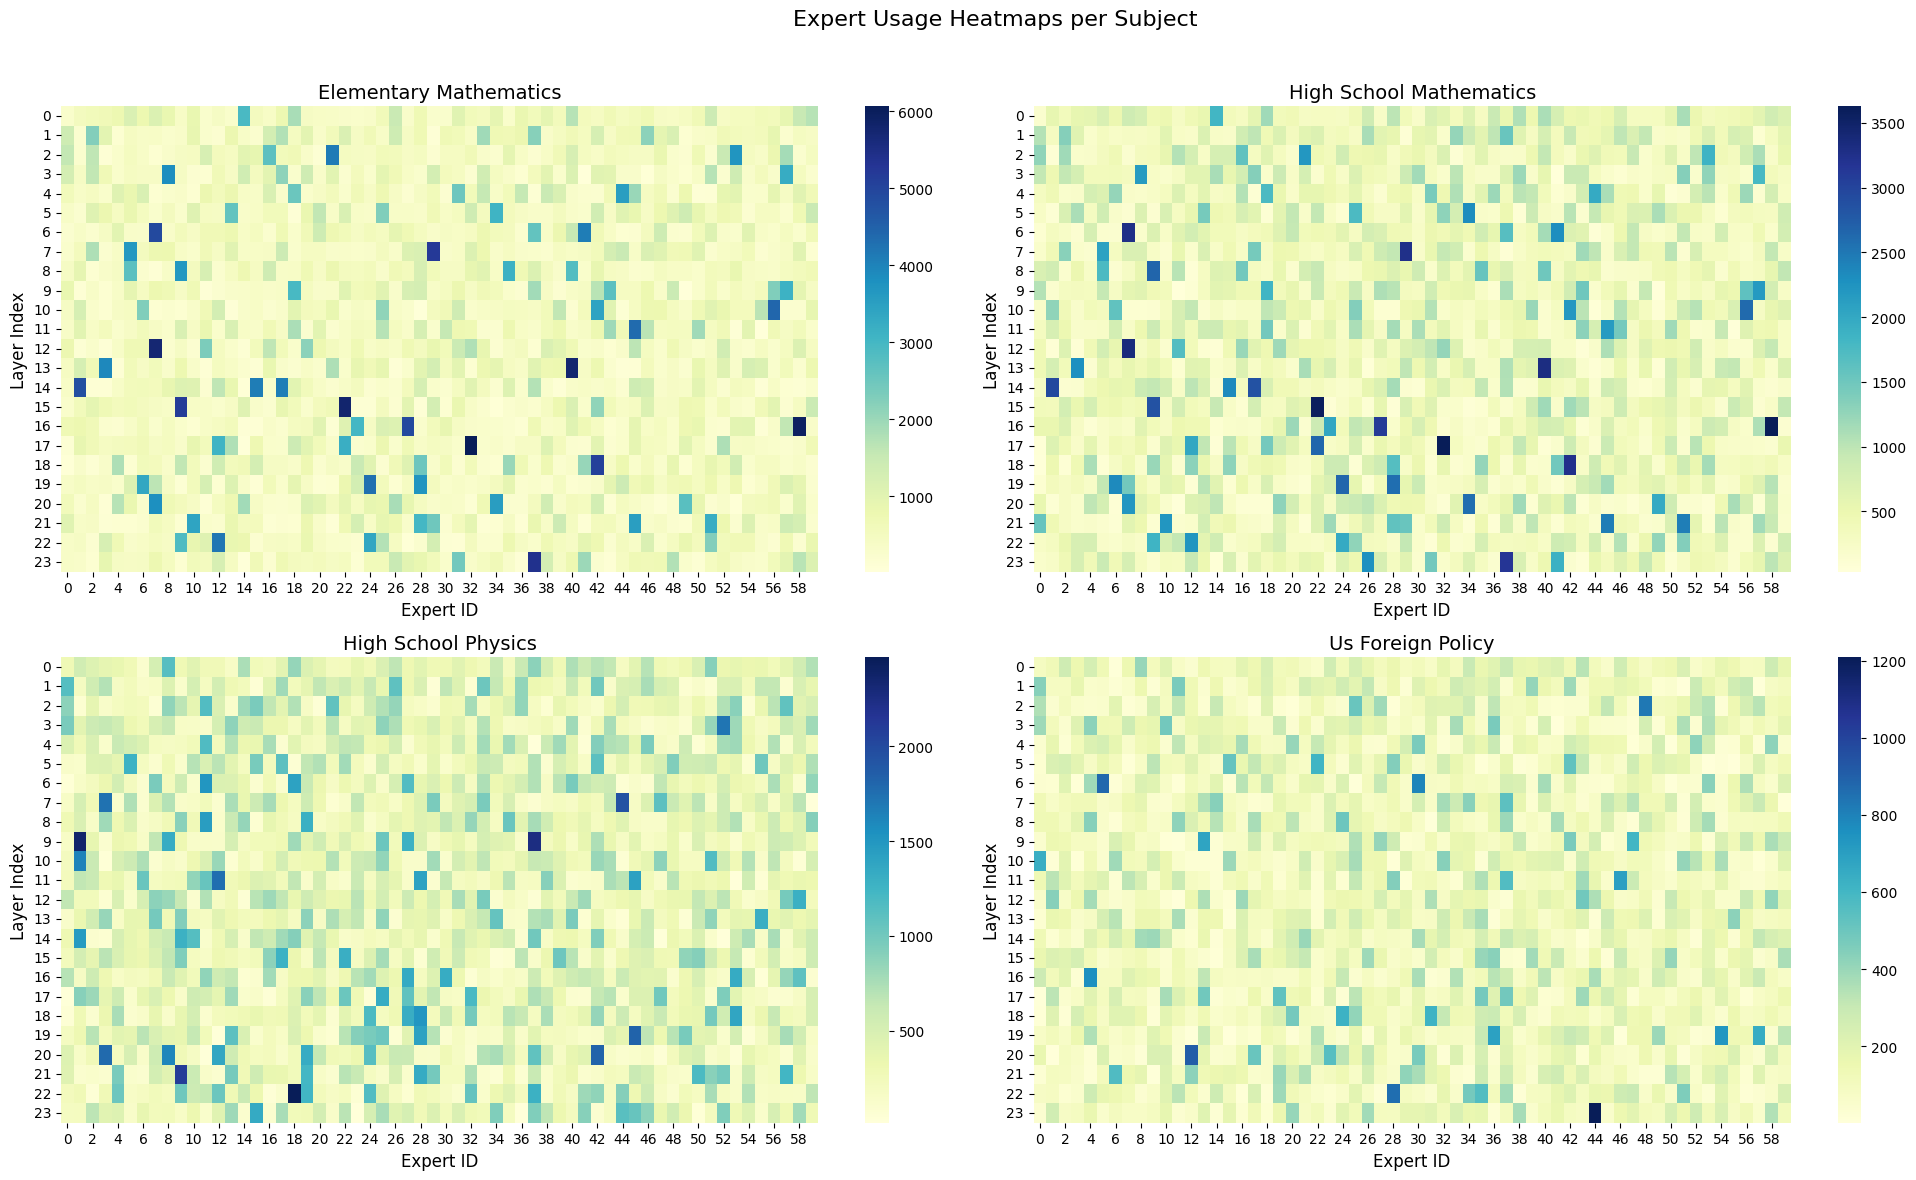

In [ ]:
# Load the .jsonl log
samples = []
with open("/content/qwen_mmlu_routing_logs_500_each.jsonl", "r") as f:
    for line in f:
        samples.append(json.loads(line.strip()))

# Build usage counters: subject -> layer -> expert -> count
subject_expert_usage = defaultdict(lambda: defaultdict(lambda: [0]*60))  # 60 routed experts

for sample in samples:
    subject = sample["subject"]
    expert_paths = sample["expert_paths"]  # shape: [num_layers][num_tokens][2]

    for layer_idx, layer in enumerate(expert_paths):
        for expert_pair in layer:
            for expert_id in expert_pair:
                subject_expert_usage[subject][layer_idx][expert_id] += 1

# Plot heatmaps for the 4 domains
subjects = ["elementary_mathematics", "high_school_mathematics",
            "high_school_physics", "us_foreign_policy"]

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for idx, subject in enumerate(subjects):
    usage = subject_expert_usage[subject]
    df = pd.DataFrame([usage[layer] for layer in sorted(usage.keys())])  # shape: [num_layers, 60]

    sns.heatmap(df, ax=axes[idx], cmap="YlGnBu", cbar=True)
    axes[idx].set_title(f"{subject.replace('_', ' ').title()}", fontsize=14)
    axes[idx].set_xlabel("Expert ID", fontsize=12)
    axes[idx].set_ylabel("Layer Index", fontsize=12)

plt.suptitle("Expert Usage Heatmaps per Subject", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 🔽 Save as PNG or PDF (you can change the filename and format)
plt.savefig("expert_usage_heatmaps.png", dpi=300)   # or use .pdf, .svg, etc.

plt.show()


### II. Compute top-k expert concentration
- for each subject, a DataFrame of top_k ratios per layer

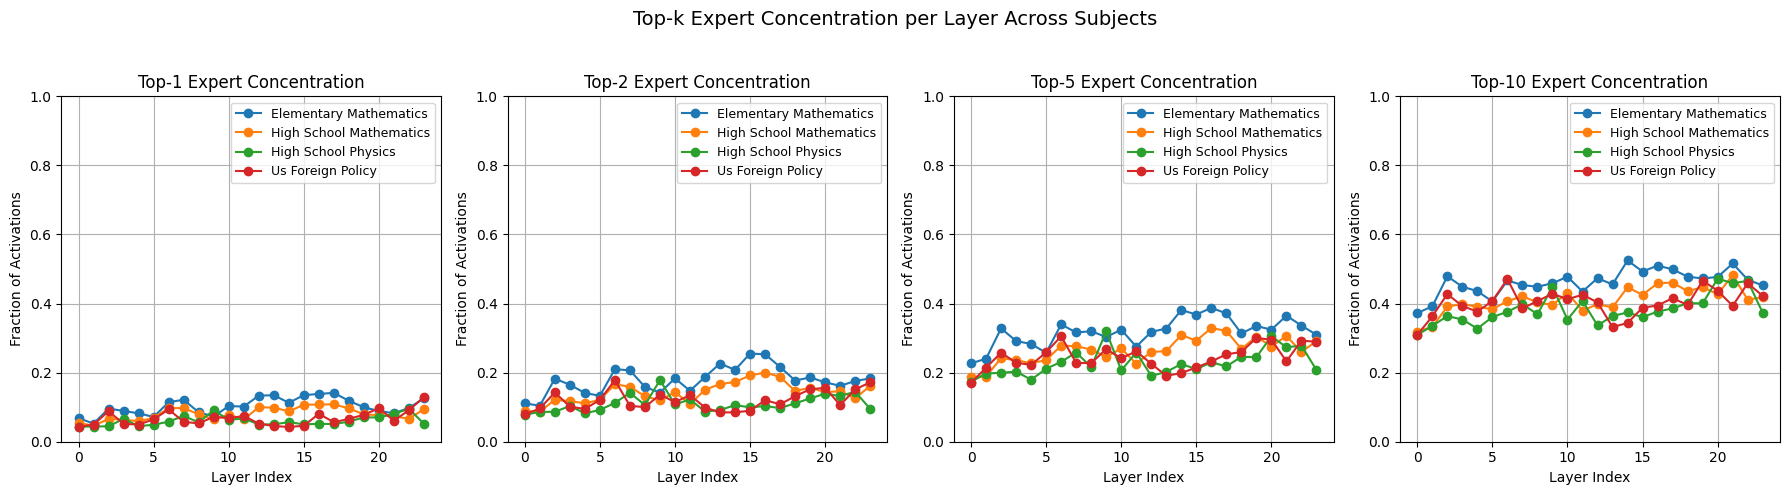

In [ ]:
# Compute top-k expert concentration: subject → DataFrame of top_k ratios per layer
topk_concentration = {}

for subject in subjects:
    usage = subject_expert_usage[subject]
    per_layer_stats = {}

    for layer, expert_counts in usage.items():
        total = sum(expert_counts)
        if total == 0:
            continue
        sorted_counts = sorted(expert_counts, reverse=True)
        top1 = sum(sorted_counts[:1]) / total
        top2 = sum(sorted_counts[:2]) / total
        top5 = sum(sorted_counts[:5]) / total
        top10 = sum(sorted_counts[:10]) / total
        per_layer_stats[layer] = {"top_1": top1, "top_2": top2, "top_5": top5, "top_10": top10}

    topk_concentration[subject] = pd.DataFrame.from_dict(per_layer_stats, orient="index")

# Set up plots: one for top-1, top-2, top-5
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
top_k_list = ["top_1", "top_2", "top_5", "top_10"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
subjects = ["elementary_mathematics", "high_school_mathematics",
            "high_school_physics", "us_foreign_policy"]

for ax, k in zip(axes, top_k_list):
    for subject, color in zip(subjects, colors):
        if k in topk_concentration[subject].columns:
            ax.plot(topk_concentration[subject].index,
                    topk_concentration[subject][k],
                    label=subject.replace("_", " ").title(),
                    marker="o", color=color)

    ax.set_title(f"{k.replace('_', '-').title()} Expert Concentration")
    ax.set_xlabel("Layer Index")
    ax.set_ylabel("Fraction of Activations")
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.legend(fontsize=9)

plt.suptitle("Top-k Expert Concentration per Layer Across Subjects", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("topk_expert_concentration_all_subjects.png", dpi=300)
plt.show()

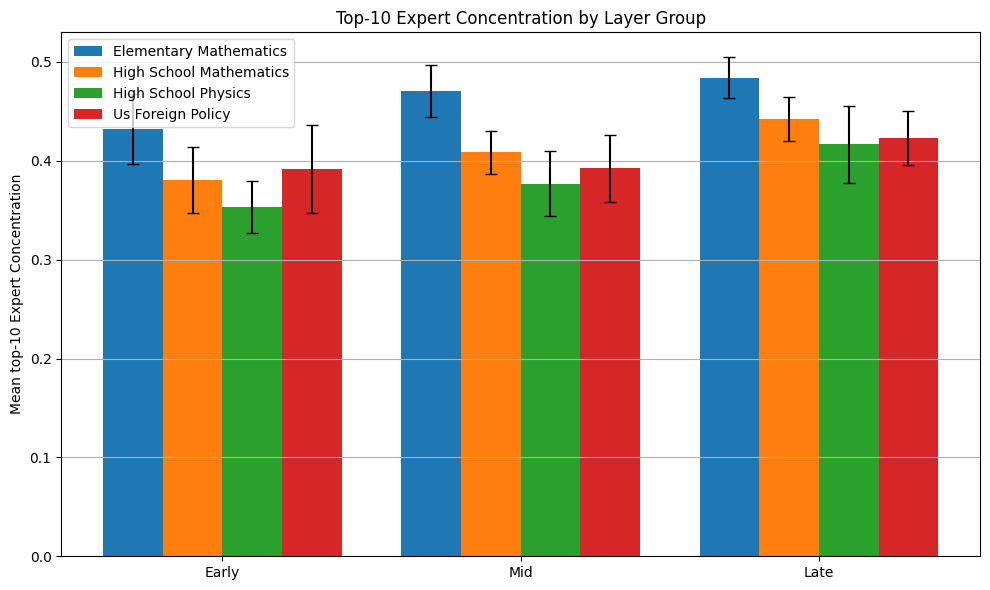

In [ ]:
# Define layer splits
layer_groups = {
    "early": range(0, 8),
    "mid": range(8, 16),
    "late": range(16, 24)
}

top_k_metric = "top_10"  # You can change to "top_1" or "top_2"
results = []

# Collect mean and stddev per subject & stage
for subject in subjects:
    df = topk_concentration[subject]
    for stage, layers in layer_groups.items():
        values = df.loc[df.index.intersection(layers)][top_k_metric].values
        if len(values) > 0:
            results.append({
                "subject": subject.replace("_", " ").title(),
                "stage": stage,
                "mean": np.mean(values),
                "std": np.std(values)
            })

# Convert to DataFrame for easy plotting
import pandas as pd
results_df = pd.DataFrame(results)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
stages = ["early", "mid", "late"]
x = np.arange(len(stages))
width = 0.2
offsets = np.linspace(-width*1.5, width*1.5, len(subjects))

for i, subject in enumerate(results_df["subject"].unique()):
    subject_data = results_df[results_df["subject"] == subject].set_index("stage").reindex(stages)
    plt.bar(x + offsets[i],
            subject_data["mean"],
            yerr=subject_data["std"],
            width=width,
            capsize=4,
            label=subject)

plt.xticks(x, [s.title() for s in stages])
plt.ylabel(f"Mean {top_k_metric.replace('_', '-')} Expert Concentration")
plt.title(f"{top_k_metric.replace('_', '-').title()} Expert Concentration by Layer Group")
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(f"{top_k_metric}_concentration_by_layer_group.png", dpi=300)
plt.show()


In [ ]:
import json
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# === Step 1: Load Routing Logs ===
path = "/content/qwen_mmlu_routing_logs_500_each.jsonl"  # Update path if needed
with open(path, "r") as f:
    samples = [json.loads(line.strip()) for line in f]

NUM_LAYERS = 24
NUM_EXPERTS = 60
TOP_K = 2
TOP_N = 200

# === Step 2: Initialize data structures ===
subject_coactivation = defaultdict(lambda: defaultdict(int))  # (l1, e1, l2, e2) → count
coactivation_seq_tracker = defaultdict(lambda: defaultdict(set))  # → set of sequence indices

# === Step 3: Accumulate token-level and sequence-level counts ===
for idx, sample in enumerate(tqdm(samples)):
    subject = sample["subject"]
    expert_paths = sample["expert_paths"]  # [layer][token][2]
    token_paths = list(zip(*expert_paths))  # [token][layer][2]

    seen_pairs = set()
    for token in token_paths:
        for l1 in range(NUM_LAYERS):
            for l2 in range(NUM_LAYERS):
                if l1 == l2:
                    continue
                for e1 in token[l1]:
                    for e2 in token[l2]:
                        # Sort to remove directional duplication
                        key = tuple(sorted([(l1, e1), (l2, e2)]))
                        subject_coactivation[subject][key] += 1
                        seen_pairs.add(key)

    for pair in seen_pairs:
        coactivation_seq_tracker[subject][pair].add(idx)

# === Step 4: Extract top N pairs per subject ===
top_pairs_by_subject = {}

for subject in subject_coactivation:
    pairs_with_counts = [
        (pair, subject_coactivation[subject][pair])
        for pair in subject_coactivation[subject]
    ]
    sorted_pairs = sorted(pairs_with_counts, key=lambda x: x[1], reverse=True)[:TOP_N]
    top_pairs_by_subject[subject] = sorted_pairs

# === Step 5: Write cleaned log ===
output_path = "/content/top_coactivated_experts_by_subject.txt"
with open(output_path, "w") as f:
    for subject, pairs in top_pairs_by_subject.items():
        f.write(f"Top cross-layer co-activated expert pairs for {subject.replace('_', ' ').title()}:\n")
        for (l1e1, l2e2), token_count in pairs:
            (l1, e1), (l2, e2) = l1e1, l2e2
            sequence_count = len(coactivation_seq_tracker[subject][(l1e1, l2e2)])
            f.write(f"  - Expert {e1} @ Layer {l1} ⇄ Expert {e2} @ Layer {l2} → "
                    f"Token Count: {token_count}, Sequence Count: {sequence_count}\n")
        f.write("\n")

print(f"log saved to: {output_path}")


100%|██████████| 899/899 [07:31<00:00,  1.99it/s]


log saved to: /content/top_coactivated_experts_by_subject.txt


### III. Co-activated experts clustering

In [13]:
samples = []
with open("/content/qwen_mmlu_routing_logs_500_each.jsonl", "r") as f:
    for line in f:
        samples.append(json.loads(line))

# Count co-activations across layers
coactivation_counts = defaultdict(int)

for sample in samples:
    paths = sample["expert_paths"]  # shape: [num_layers][num_tokens][2]

    # Transpose to iterate by token
    num_layers = len(paths)
    num_tokens = len(paths[0])

    for t in range(num_tokens):
        token_experts = [(l, expert)
                         for l in range(num_layers)
                         for expert in paths[l][t]]

        # Get all unordered cross-layer expert pairs
        for (l1, e1), (l2, e2) in combinations(token_experts, 2):
            if l1 != l2:
                key = tuple(sorted([(l1, e1), (l2, e2)]))
                coactivation_counts[key] += 1


<ipython-input-14-947c69e19305>:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


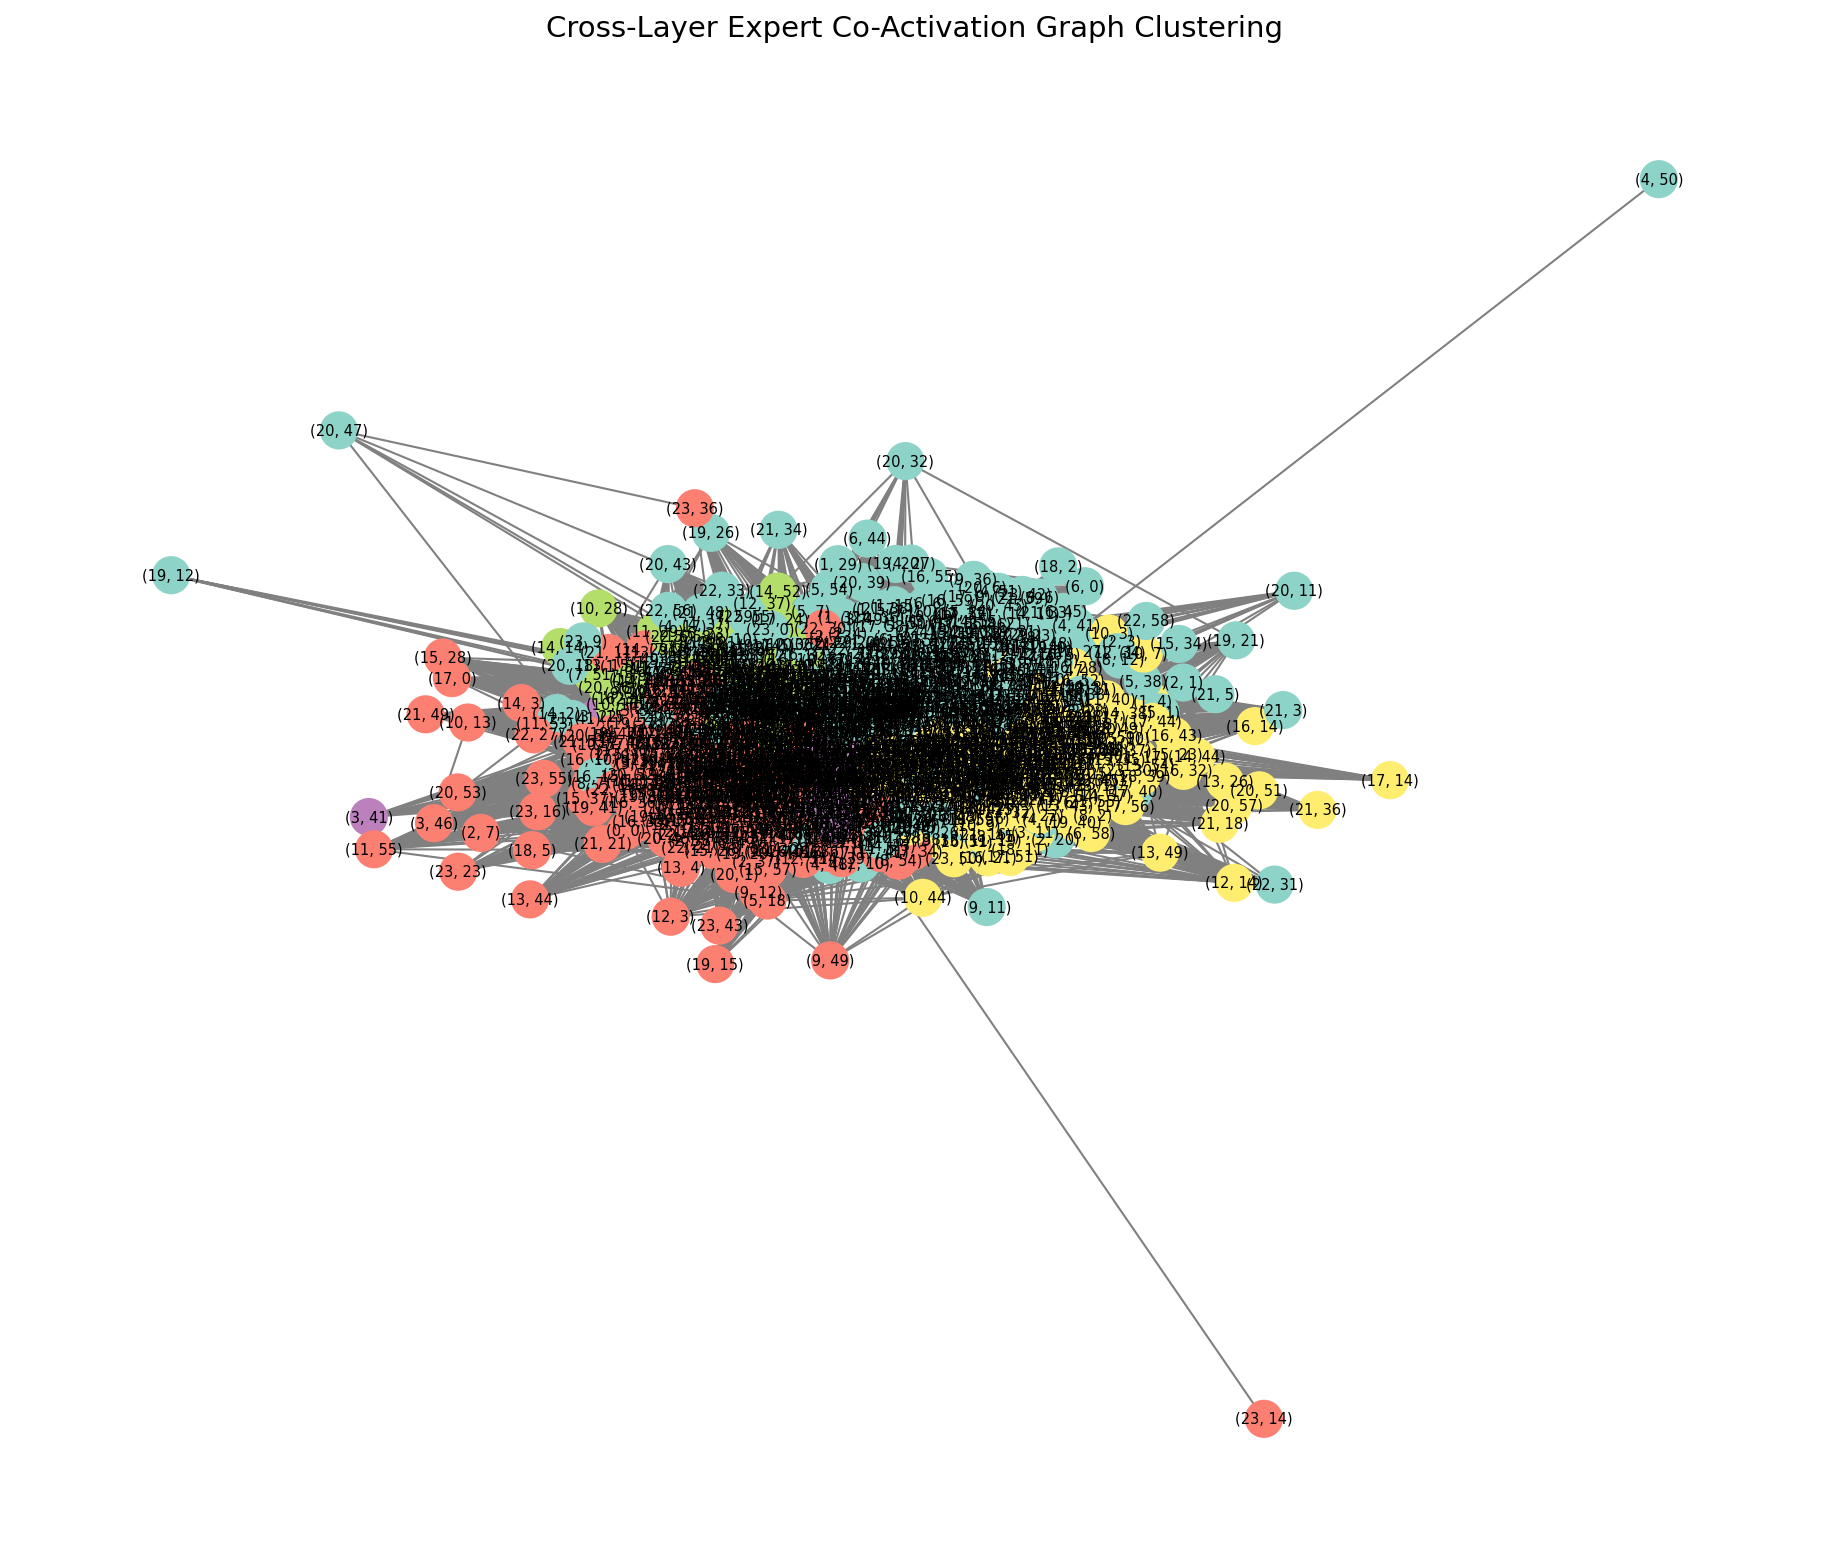

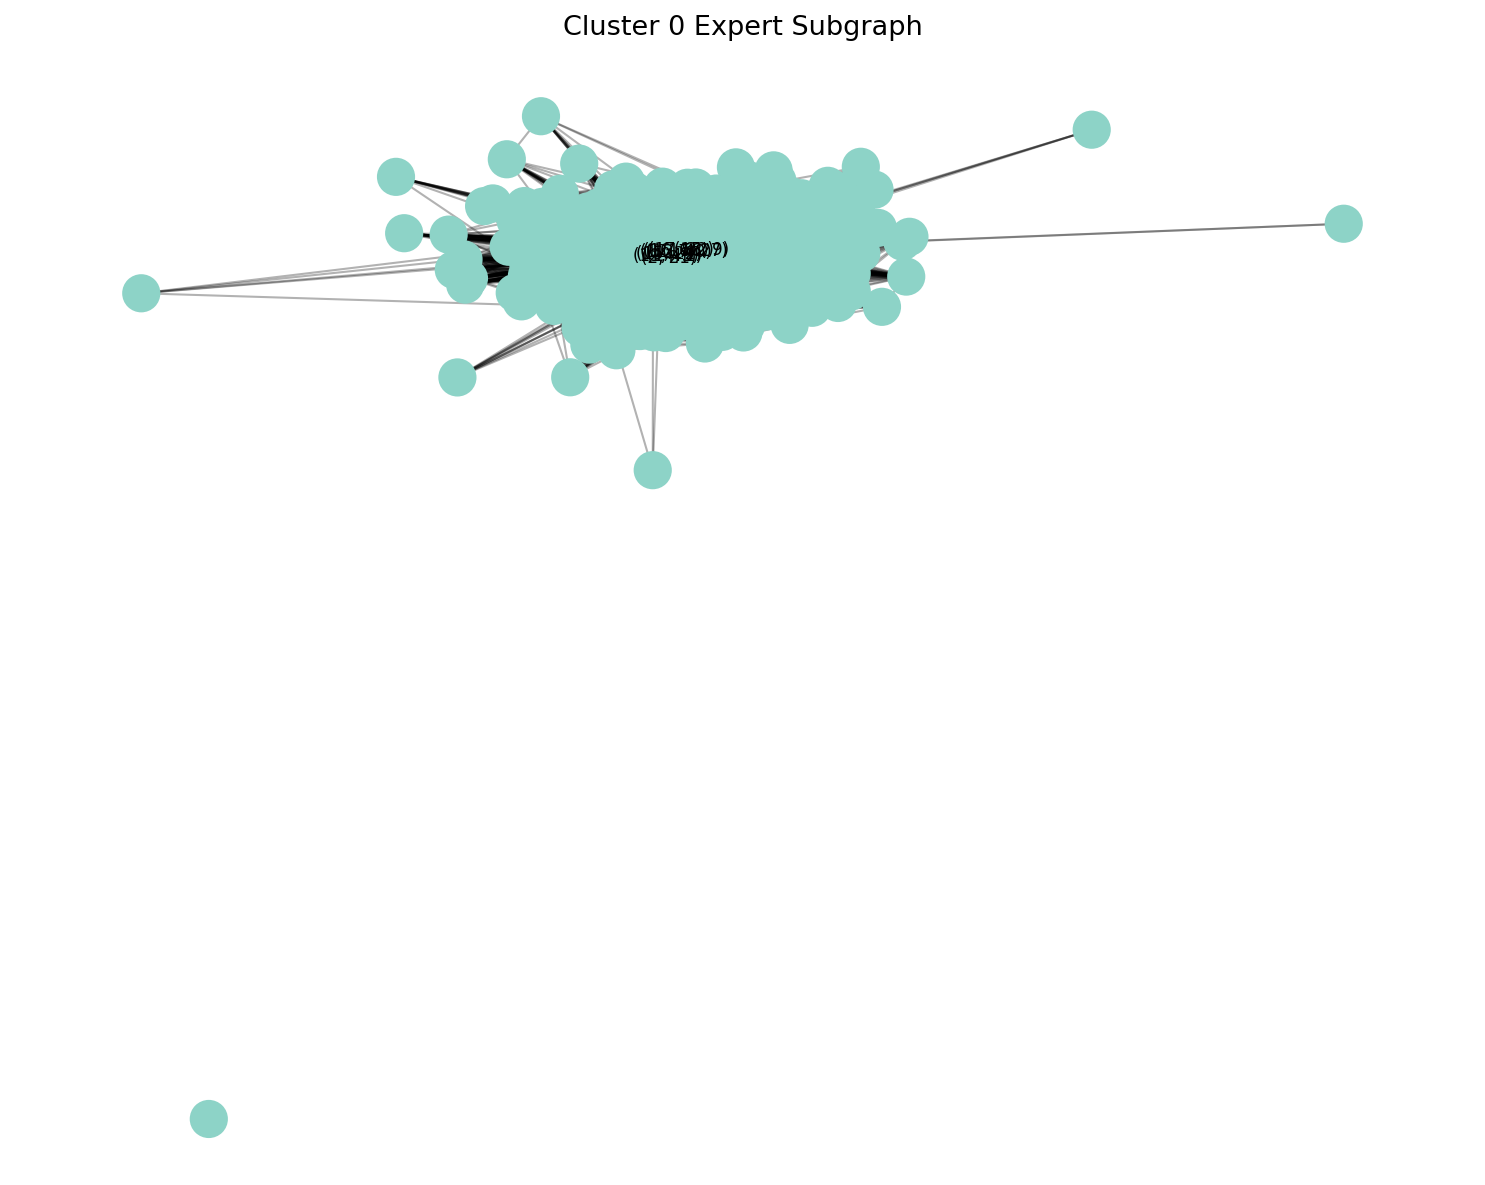

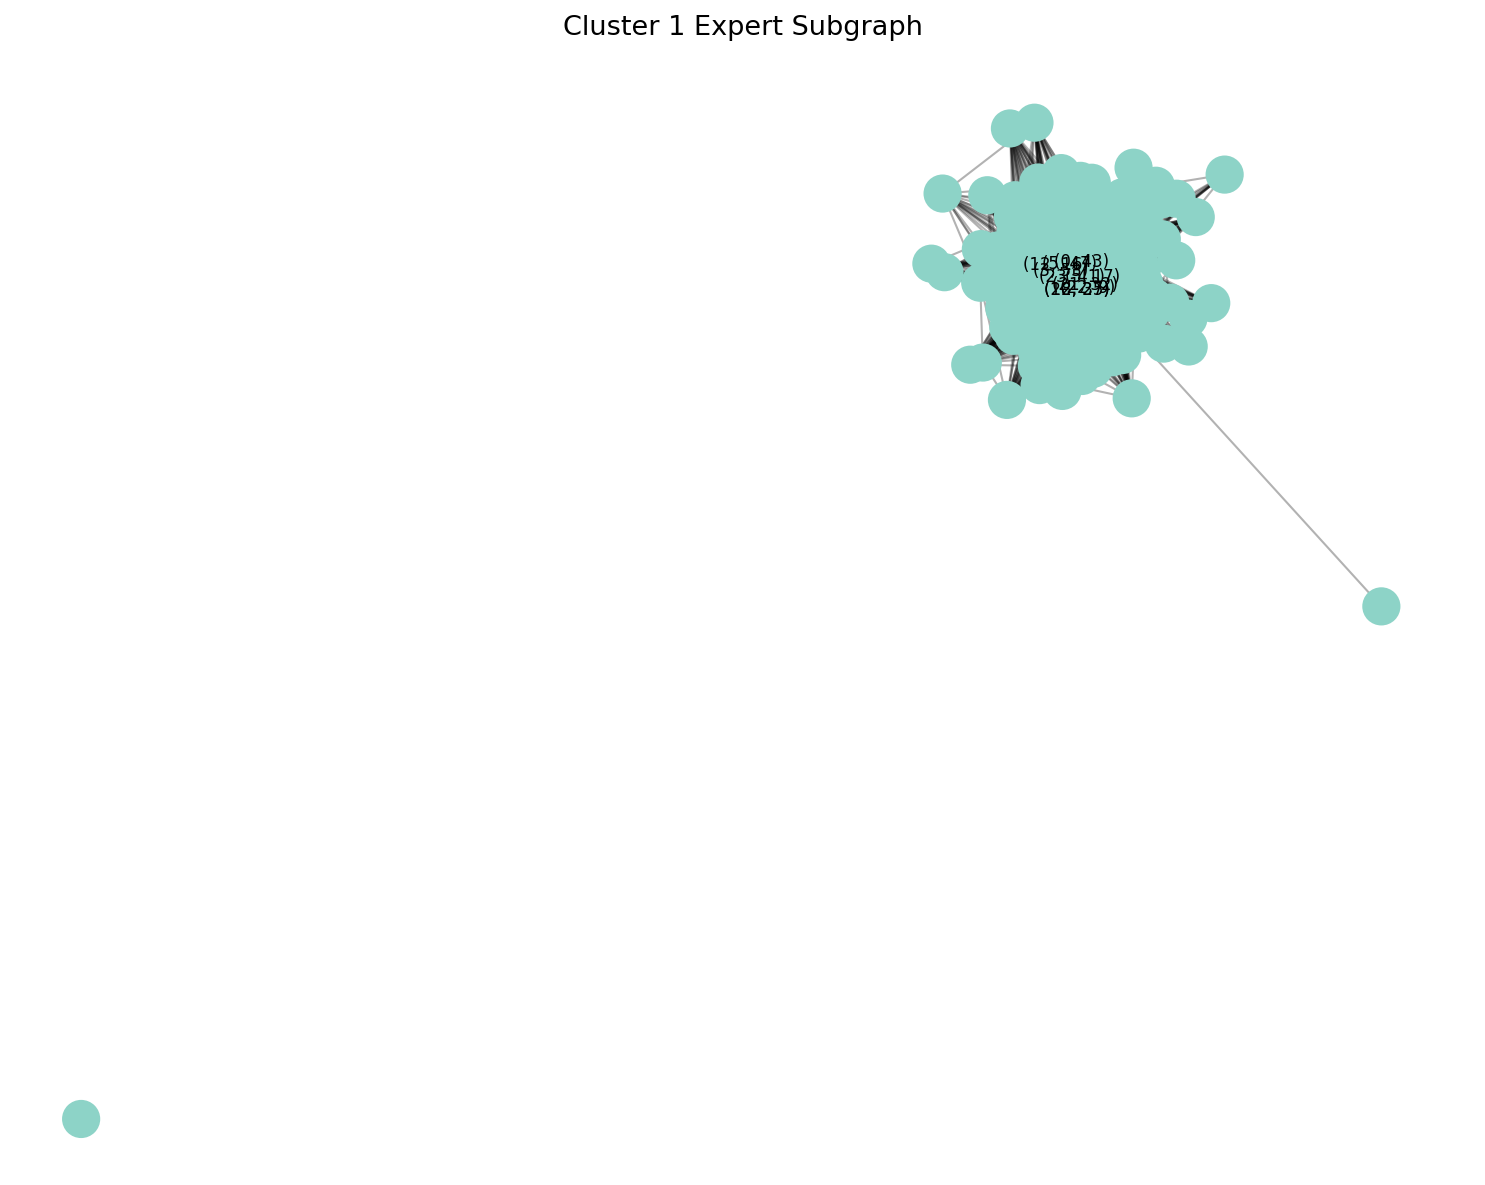

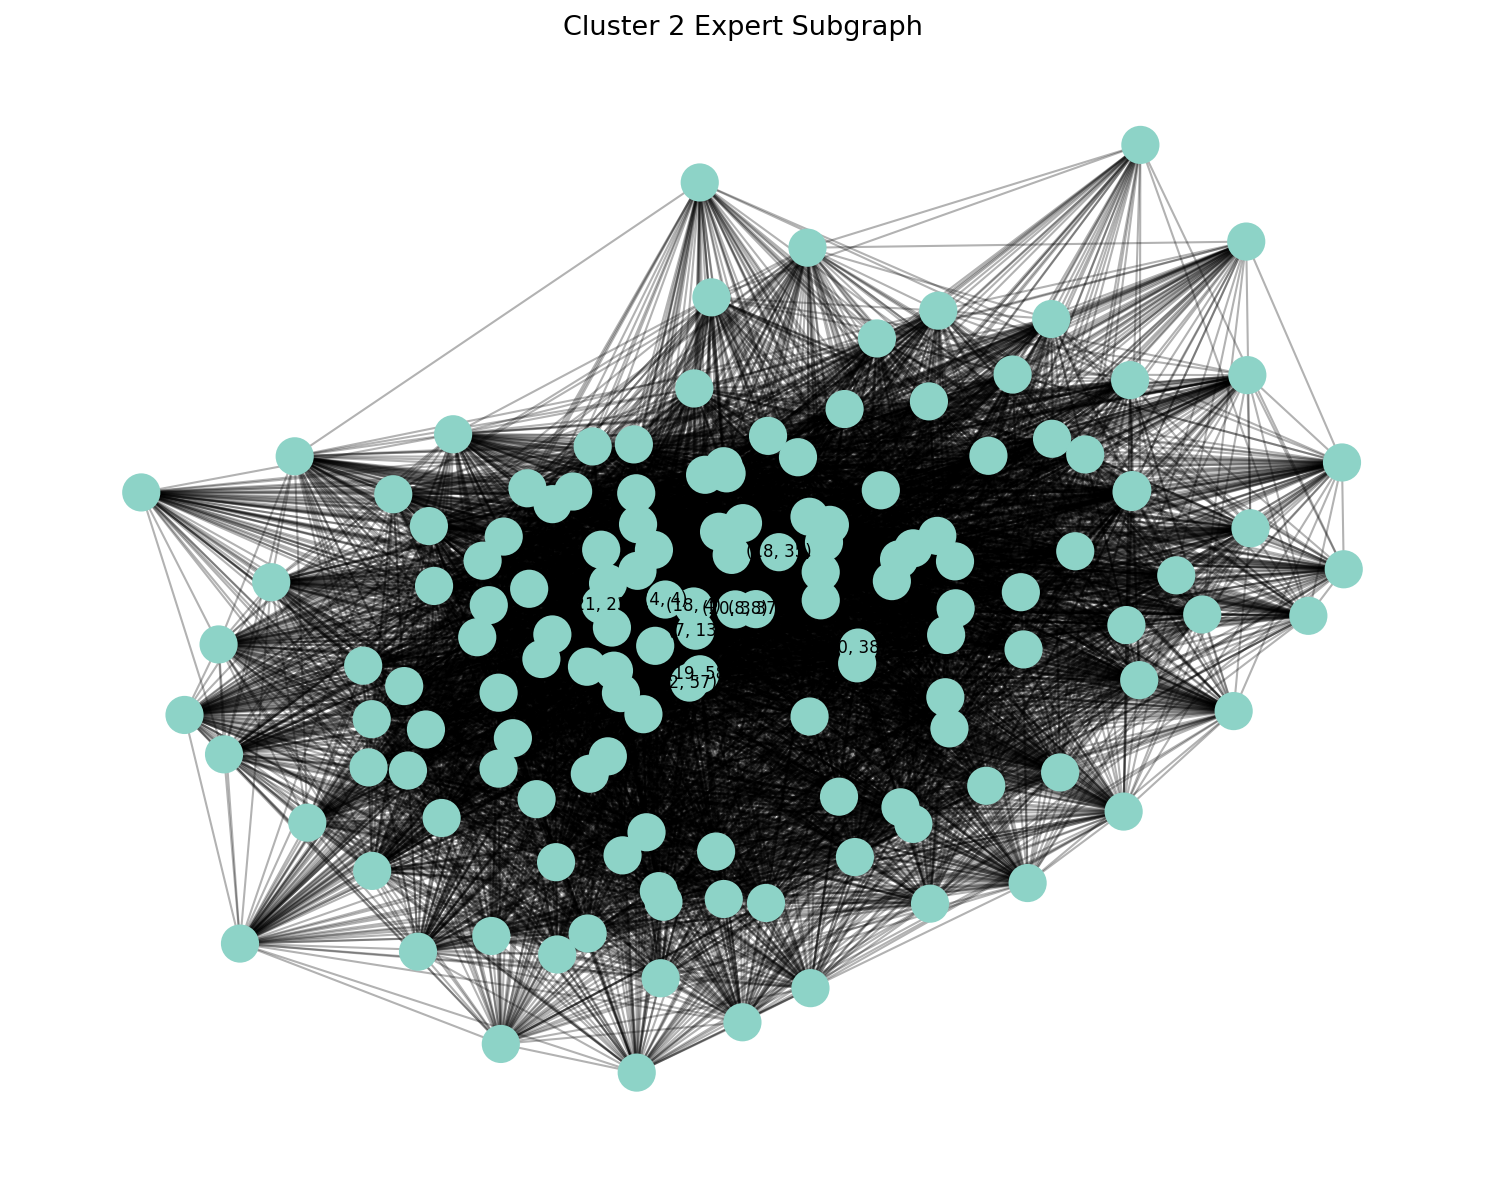

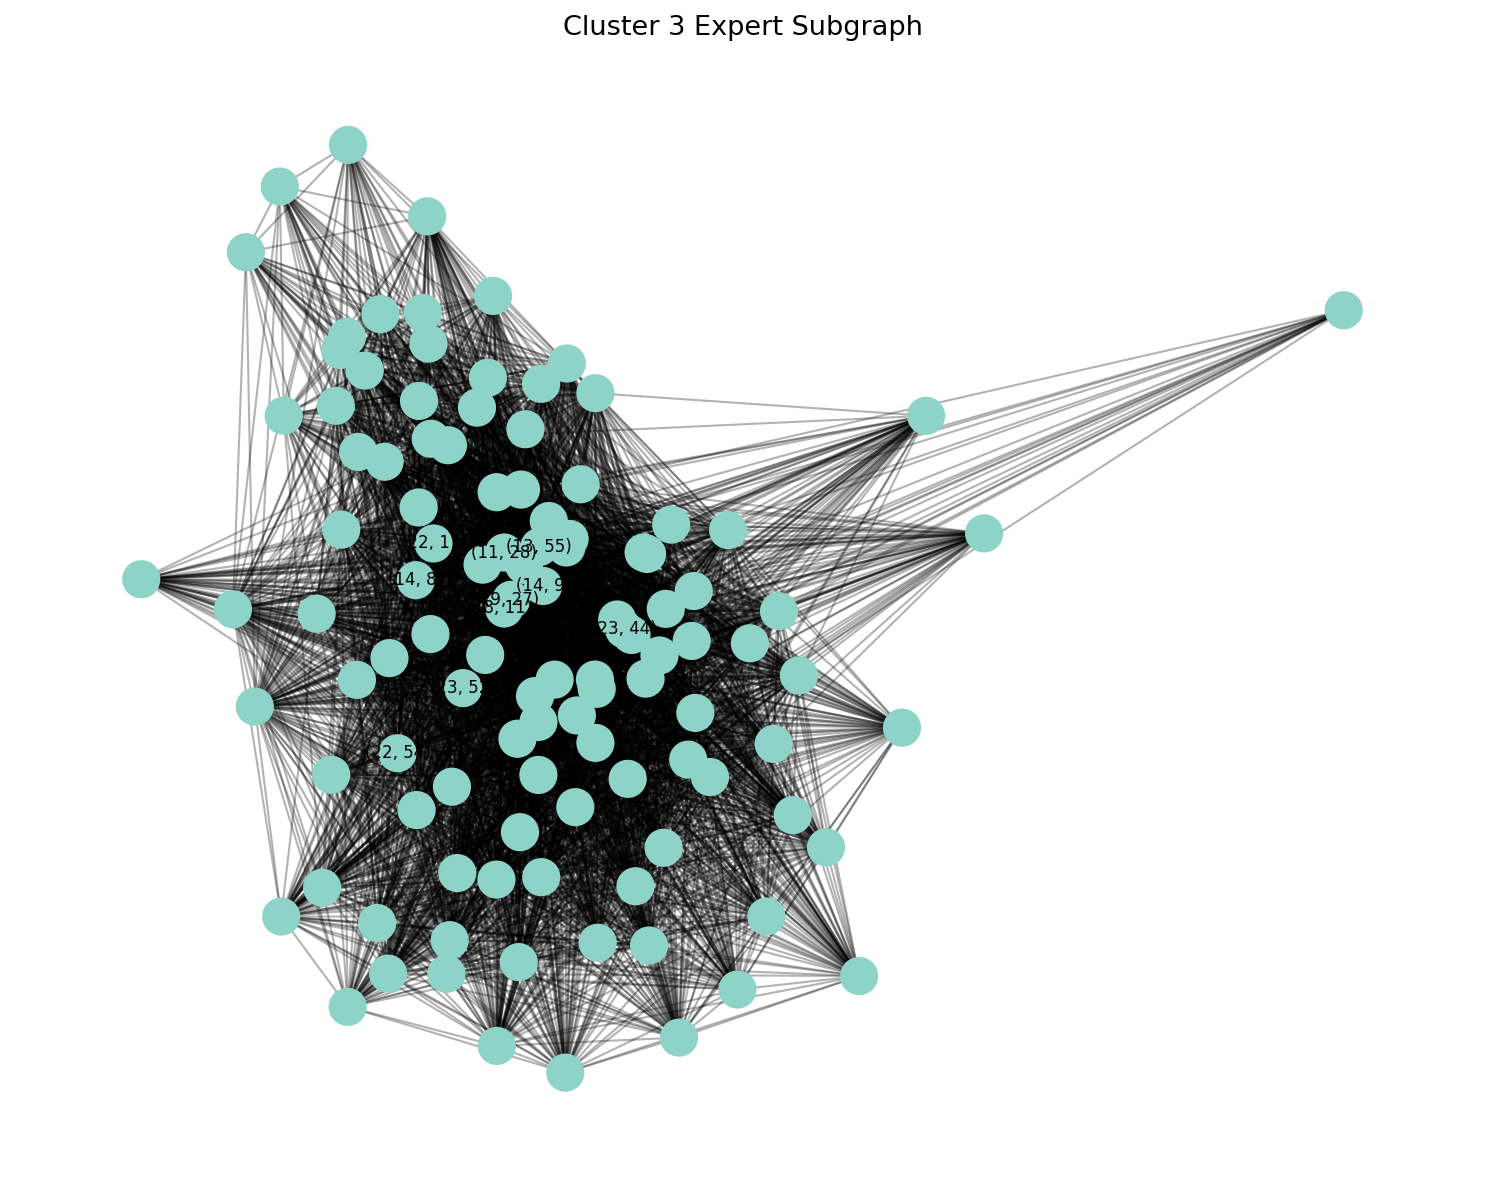

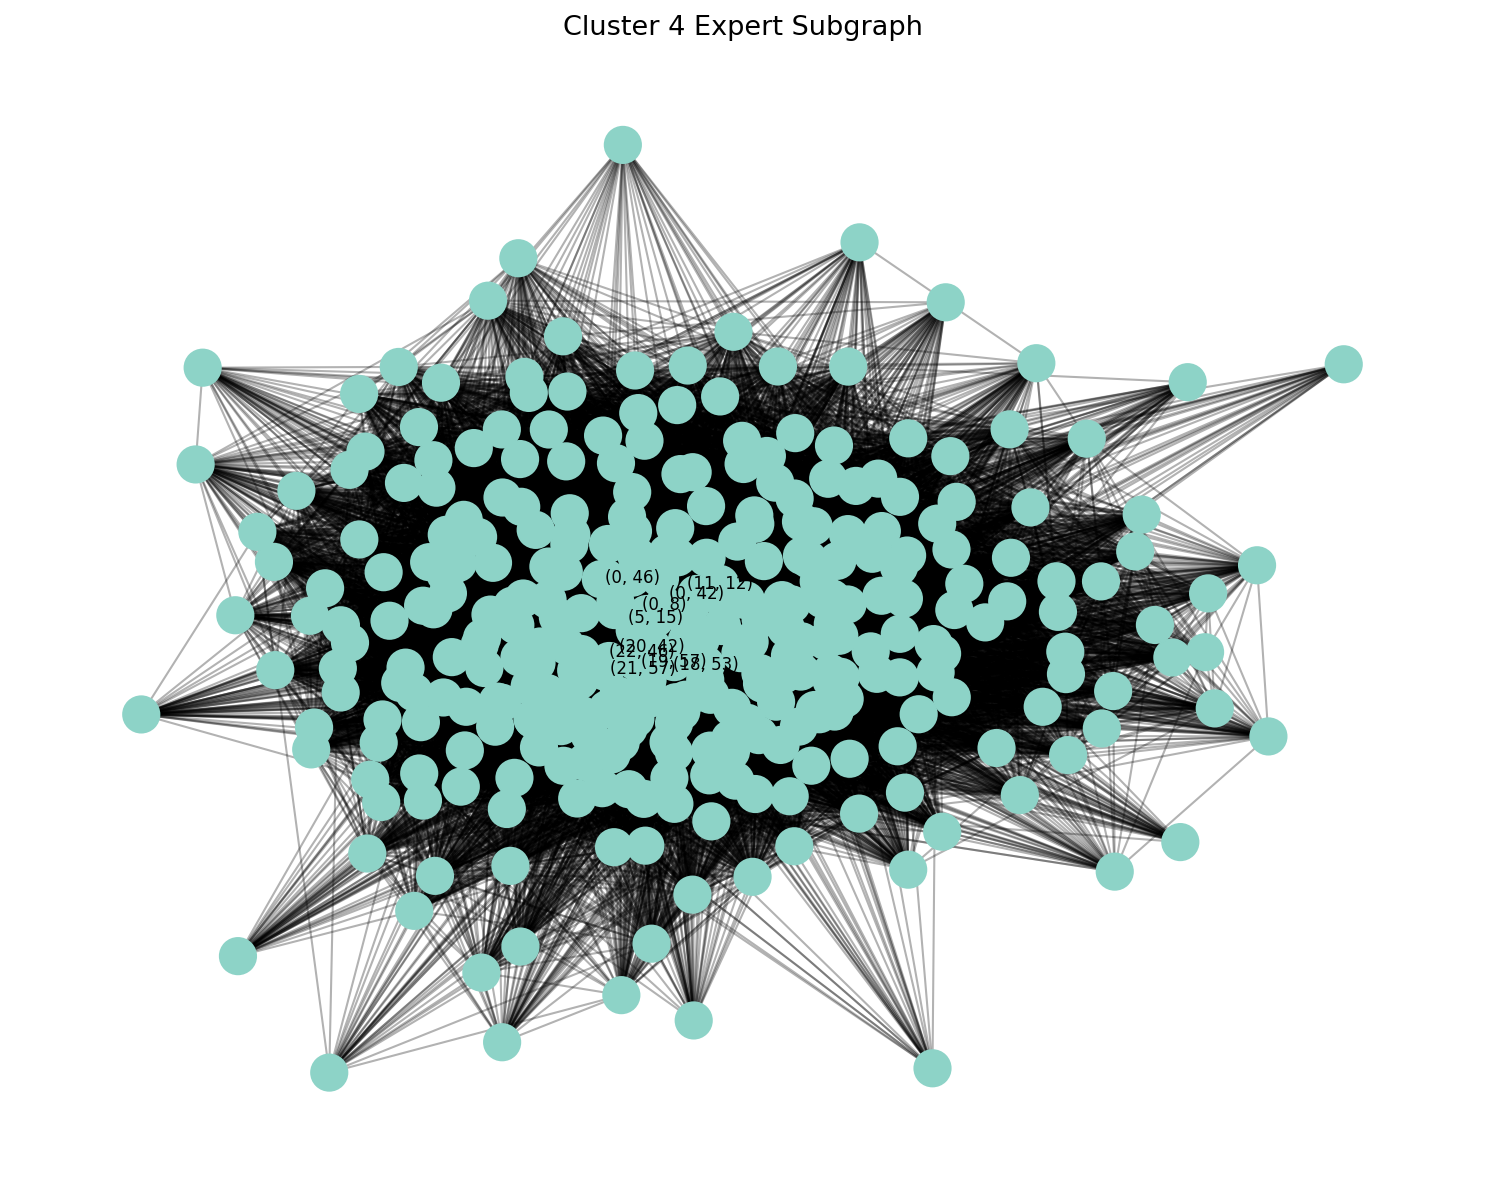

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.cluster import SpectralClustering

# -----------------------------
# 1. Build Graph from Coactivation Log
# -----------------------------

# Example coactivation_counts: {(layer1, expert1), (layer2, expert2): count}
# This should be loaded from your log or built from routing data
# Example:
# coactivation_counts = {
#     ((16, 58), (17, 32)): 5289,
#     ((12, 7), (15, 22)): 5142,
#     ...
# }

# Extract expert nodes
expert_ids = sorted(set([a for a, b in coactivation_counts.keys()] + [b for a, b in coactivation_counts.keys()]))

# Map to indices for matrix
node_to_idx = {n: i for i, n in enumerate(expert_ids)}
idx_to_node = {i: n for n, i in node_to_idx.items()}

# Build adjacency matrix
N = len(expert_ids)
M = np.zeros((N, N))

for (a, b), count in coactivation_counts.items():
    i, j = node_to_idx[a], node_to_idx[b]
    M[i, j] = count
    M[j, i] = count  # Symmetric

# -----------------------------
# 2. Spectral Clustering
# -----------------------------
num_clusters = 5
clustering = SpectralClustering(n_clusters=num_clusters, affinity='precomputed', random_state=42)
labels = clustering.fit_predict(M)

# -----------------------------
# 3. Build Graph for Visualization
# -----------------------------
G = nx.Graph()
for node in expert_ids:
    G.add_node(node)

for (a, b), count in coactivation_counts.items():
    if count > 50:  # Only strong co-activations
        G.add_edge(a, b, weight=count)

# Remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

# Assign cluster labels
for node, label in zip(expert_ids, labels):
    if node in G.nodes:
        G.nodes[node]["cluster"] = label

# -----------------------------
# 4. Visualize Full Graph with Clusters
# -----------------------------
plt.figure(figsize=(12, 10), dpi=150)
pos = nx.spring_layout(G, k=0.5, seed=42)
node_colors = [G.nodes[n]["cluster"] for n in G.nodes()]
nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.Set3,
        with_labels=True, font_size=7, edge_color="gray")
plt.title("Cross-Layer Expert Co-Activation Graph Clustering", fontsize=14)
plt.tight_layout()
plt.savefig("expert_cluster_full_graph.png")
plt.show()

# -----------------------------
# 5. Per-Cluster Subgraph Visualizations
# -----------------------------
for cluster_id in range(num_clusters):
    sub_nodes = [n for n in G.nodes if G.nodes[n]["cluster"] == cluster_id]
    subG = G.subgraph(sub_nodes)
    sub_pos = nx.spring_layout(subG, k=0.5, seed=42)

    plt.figure(figsize=(10, 8), dpi=150)
    nx.draw_networkx_nodes(subG, sub_pos, node_color=[cluster_id]*len(sub_nodes),
                           cmap=plt.cm.Set3, node_size=300)
    nx.draw_networkx_edges(subG, sub_pos, alpha=0.3)

    # Show top 10 degree nodes with labels
    top_nodes = sorted(subG.degree, key=lambda x: x[1], reverse=True)[:10]
    label_dict = {n: str(n) for n, _ in top_nodes if n in sub_pos}
    nx.draw_networkx_labels(subG, sub_pos, labels=label_dict, font_size=8)

    plt.title(f"Cluster {cluster_id} Expert Subgraph", fontsize=13)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"cluster_{cluster_id}_graph.png", bbox_inches="tight")
    plt.show()


# INFERENCE AND SWAPPING ANALYSIS

In [1]:
!pip install -q transformers accelerate
!pip install -U fsspec datasets
!pip install -q tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Fou

In [2]:
# storing mmlu elementary math samples

from datasets import load_dataset
import random
import json

# === CONFIG ===
DOMAINS = ["elementary_mathematics", "high_school_mathematics", "high_school_physics", "us_foreign_policy"]
SAMPLES_PER_DOMAIN = 500
OUTPUT_PATH = "/content/mmlu_samples.jsonl"

# === Load full MMLU dataset ===
dataset = load_dataset("cais/mmlu", "all", split="test")

# === Filter and sample ===
filtered = [ex for ex in dataset if ex["subject"] in DOMAINS]

# Group by subject
grouped = {domain: [] for domain in DOMAINS}
for ex in filtered:
    grouped[ex["subject"]].append(ex)

# Sample N per domain
final_samples = []
for domain in DOMAINS:
    examples = grouped[domain]
    sampled = random.sample(examples, min(SAMPLES_PER_DOMAIN, len(examples)))
    for ex in sampled:
        final_samples.append({
            "subject": ex["subject"],
            "question": ex["question"],
            "choices": ex["choices"],
            "ground_truth": ex["answer"]
        })

# === Save to JSONL ===
with open(OUTPUT_PATH, "w") as f:
    for sample in final_samples:
        f.write(json.dumps(sample) + "\n")

print(f"Saved {len(final_samples)} MMLU samples to {OUTPUT_PATH}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/138k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/408k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/76.5k [00:00<?, ?B/s]

auxiliary_train-00000-of-00001.parquet:   0%|          | 0.00/47.5M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/14042 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1531 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/285 [00:00<?, ? examples/s]

Generating auxiliary_train split:   0%|          | 0/99842 [00:00<?, ? examples/s]

Saved 899 MMLU samples to /content/mmlu_samples.jsonl


In [3]:
import json
import os
from collections import defaultdict
from tqdm import tqdm

# === Config ===
input_sample_path = "/content/mmlu_samples_truncated.jsonl"
input_routing_path = "/content/qwen_mmlu_routing_logs_100_each.jsonl"
domain_expert_pair_path = "/content/frequently_coactivated_experts_across_domains.jsonl"
output_dir = "/content/filtered_top_coactivated"

min_token_threshold = 3  # Minimum tokens for a pair to count

# === Load Data ===
with open(input_sample_path, "r") as f:
    samples = [json.loads(line) for line in f]

with open(input_routing_path, "r") as f:
    routing_logs = [json.loads(line) for line in f]

with open(domain_expert_pair_path, "r") as f:
    domain_expert_pairs = json.load(f)
print(len(samples), len(routing_logs), len(domain_expert_pairs))
assert len(samples) == len(routing_logs), "Mismatch between samples and logs!"

# === Organize by Domain ===
samples_by_domain = defaultdict(list)
logs_by_domain = defaultdict(list)

for sample, log in zip(samples, routing_logs):
    subject = sample["subject"]
    samples_by_domain[subject].append(sample)
    logs_by_domain[subject].append(log)

# === Filtering ===
os.makedirs(output_dir, exist_ok=True)

for domain, expert_pairs in domain_expert_pairs.items():
    if domain not in samples_by_domain:
        print(f"[{domain}] No samples found, skipping.")
        continue

    required_matches = len(expert_pairs) // 2
    domain_samples = samples_by_domain[domain]
    domain_logs = logs_by_domain[domain]

    filtered_samples = []
    filtered_logs = []

    print(f"Filtering {domain} with {len(domain_samples)} samples and {len(expert_pairs)} expert pairs")

    for sample, log in tqdm(zip(domain_samples, domain_logs), total=len(domain_samples)):
        expert_paths = log['expert_paths']
        num_tokens = len(expert_paths[0])

        match_count = 0
        for (layer_a, expert_a), (layer_b, expert_b) in expert_pairs:
            hits = sum(
                1 for t in range(num_tokens)
                if expert_a in expert_paths[layer_a][t] and expert_b in expert_paths[layer_b][t]
            )
            if hits >= min_token_threshold:
                match_count += 1

        if match_count >= required_matches:
            filtered_samples.append(sample)
            filtered_logs.append(log)

    # === Save Results ===
    sample_out = os.path.join(output_dir, f"{domain}_samples.jsonl")
    log_out = os.path.join(output_dir, f"{domain}_routing_logs.jsonl")

    with open(sample_out, "w") as f:
        for s in filtered_samples:
            f.write(json.dumps(s) + "\n")

    with open(log_out, "w") as f:
        for l in filtered_logs:
            f.write(json.dumps(l) + "\n")

    print(f"[{domain}] Retained {len(filtered_samples)} / {len(domain_samples)} samples")


400 400 4
Filtering elementary_mathematics with 100 samples and 5 expert pairs


100%|██████████| 100/100 [00:00<00:00, 11341.78it/s]

[elementary_mathematics] Retained 99 / 100 samples


Filtering high_school_mathematics with 100 samples and 5 expert pairs


100%|██████████| 100/100 [00:00<00:00, 5783.97it/s]


[high_school_mathematics] Retained 98 / 100 samples
Filtering high_school_physics with 100 samples and 5 expert pairs


100%|██████████| 100/100 [00:00<00:00, 8962.57it/s]


[high_school_physics] Retained 93 / 100 samples
Filtering us_foreign_policy with 100 samples and 5 expert pairs


100%|██████████| 100/100 [00:00<00:00, 10810.90it/s]

[us_foreign_policy] Retained 90 / 100 samples


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import json
import os
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import copy
import random

# === Config ===
model_name = "Qwen/Qwen1.5-MoE-A2.7B"
base_dir = "/content/drive/MyDrive/moe_experiments"
filtered_data_dir = f"{base_dir}/filtered_top_coactivated"
output_dir = f"{base_dir}/inference_outputs"
domain_expert_pair_path = f"{base_dir}/frequently_coactivated_experts_across_domains.jsonl"# Load and convert into dictionary
with open(domain_expert_pair_path, "r") as f:
    domain_expert_pairs = json.load(f)
# # Domain-specific expert pairs (assumes you've loaded from domain_expert_pairs.json)
# domain_expert_pairs = {
#     "elementary_mathematics": [(16, 58), (17, 32), (12, 7)],
#     "high_school_mathematics": [(16, 58), (17, 32), (13, 40)],
#     "high_school_physics": [(7, 44), (9, 37), (11, 28)],
#     "us_foreign_policy": [(22, 28), (23, 44), (6, 5)],
# }

# === Model + Tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16, trust_remote_code=True)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/919 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/416k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model-00006-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/668M [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/144 [00:00<?, ?B/s]

Qwen2MoeForCausalLM(
  (model): Qwen2MoeModel(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-23): 24 x Qwen2MoeDecoderLayer(
        (self_attn): Qwen2MoeSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): Qwen2MoeRotaryEmbedding()
        )
        (mlp): Qwen2MoeSparseMoeBlock(
          (gate): Linear(in_features=2048, out_features=60, bias=False)
          (experts): ModuleList(
            (0-59): 60 x Qwen2MoeMLP(
              (gate_proj): Linear(in_features=2048, out_features=1408, bias=False)
              (up_proj): Linear(in_features=2048, out_features=1408, bias=False)
              (down_proj): Linear(in_features=1408, out_features=2048, bias=False)
        

In [3]:
# === Prompt Template ===
def construct_prompt(sample):
    prompt = f"Question: {sample['question']}\n"
    for i, option in enumerate(sample["choices"]):
        label = chr(ord("A") + i)
        prompt += f"({label}) {option}\n"
    prompt += "Let's think step by step.\nFinal Answer: Option"
    return prompt

In [4]:
# === Expert Swap Function ===
def swap_experts(model, pair_a, pair_b):
    l1, e1 = pair_a
    l2, e2 = pair_b
    expert_a = model.model.layers[l1].mlp.experts[e1]
    expert_b = model.model.layers[l2].mlp.experts[e2]

    a_params = {
        "gate_proj": copy.deepcopy(expert_a.gate_proj.state_dict()),
        "up_proj": copy.deepcopy(expert_a.up_proj.state_dict()),
        "down_proj": copy.deepcopy(expert_a.down_proj.state_dict())
    }
    b_params = {
        "gate_proj": copy.deepcopy(expert_b.gate_proj.state_dict()),
        "up_proj": copy.deepcopy(expert_b.up_proj.state_dict()),
        "down_proj": copy.deepcopy(expert_b.down_proj.state_dict())
    }

    expert_a.gate_proj.load_state_dict(b_params["gate_proj"])
    expert_a.up_proj.load_state_dict(b_params["up_proj"])
    expert_a.down_proj.load_state_dict(b_params["down_proj"])

    expert_b.gate_proj.load_state_dict(a_params["gate_proj"])
    expert_b.up_proj.load_state_dict(a_params["up_proj"])
    expert_b.down_proj.load_state_dict(a_params["down_proj"])

    print(f"Swapped Expert {e1} @ Layer {l1} with Expert {e2} @ Layer {l2}")


In [5]:
# === Inference Function ===
def run_inference(domain, expert_pairs, mode="original"):
    print(f"\n🔍 Running: {mode.upper()} | Domain: {domain}")

    sample_path = os.path.join(filtered_data_dir, f"{domain}_samples.jsonl")
    with open(sample_path) as f:
        samples = [json.loads(line) for line in f]

    random_swaps = []
    if mode == "correct_swap":
        for pair in expert_pairs:
            swap_experts(model, pair, pair[::-1])
    elif mode == "random_swap":
        random.seed(42)
        all_layers = list(range(len(model.model.layers)))
        for (l1, e1) in expert_pairs:
            while True:
                l2 = random.choice(all_layers)
                e2 = random.randint(0, len(model.model.layers[l2].mlp.experts) - 1)
                if (l2, e2) not in expert_pairs and (l2 != l1 or e2 != e1):
                    break
            swap_experts(model, (l1, e1), (l2, e2))
            random_swaps.append([(l1, e1), (l2, e2)])

    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{domain}_{mode}_outputs.jsonl")

    with open(output_path, "w") as f:
        cnt_samples = 0
        for sample in tqdm(samples, desc=f"Inference [{domain}]"):
            if cnt_samples >= 10:
                break
            cnt_samples += 1
            prompt = construct_prompt(sample)
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

            with torch.no_grad():
                outputs = model.generate(**inputs, max_new_tokens=128, pad_token_id=tokenizer.eos_token_id)
                decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
            print(decoded.strip())
            f.write(json.dumps({
                "subject": sample["subject"],
                "question": sample["question"],
                "choices": sample["choices"],
                "ground_truth": sample["ground_truth"],
                "model_output": decoded.strip()
            }) + "\n")

    print(f"Saved to: {output_path}")
    if mode == "correct_swap":
        for pair in expert_pairs:
            swap_experts(model, pair, pair[::-1])
    elif mode == "random_swap":
        for pair in random_swaps:
            swap_experts(model, pair[0], pair[1])

In [ ]:
# === Run across domains ===
mode = "original"  # "original", "correct_swap", or "random_swap"
for domain, pairs in domain_expert_pairs.items():
    run_inference(domain, expert_pairs=pairs, mode=mode)


🔍 Running: ORIGINAL | Domain: elementary_mathematics


Inference [elementary_mathematics]:   1%|          | 1/99 [00:46<1:16:30, 46.84s/it]

Question: What expression can be used to show 270,240 written in expanded form?
(A) 200,000 + 7,000 + 200 + 4
(B) 200,000 + 7,000 + 200 + 40
(C) 200,000 + 70,000 + 200 + 40
(D) 200,000 + 70,000 + 2,000 + 40
Let's think step by step.
Final Answer: Option (B)
Explanation: To show 270,240 written in expanded form, we need to write it as a sum of its individual parts. The number 270,240 can be written as 200,000 + 70,000 + 200 + 40. Therefore, the expression that can be used to show 270,240 written in expanded form is (B) 200,000 + 70,000 + 200 + 40.


Inference [elementary_mathematics]:   2%|▏         | 2/99 [01:26<1:08:55, 42.63s/it]

Question: The volume, V, of any cube with a side length, s, can be determined using the formula V = s^3. What is the volume, in cubic centimeters, of a cube with a side length of 2.3 centimeters?
(A) 5.29
(B) 6.9
(C) 8.027
(D) 12.167
Let's think step by step.
Final Answer: Option (A) 5.29
The volume of a cube is determined by cubing the length of one of its sides. In this case, the side length is 2.3 centimeters. Therefore, the volume of the cube is:

V = s^3
V = 2.3^3
V = 12.167

Therefore, the volume of the cube is 12.167 cubic centimeters, which is closest to option (A) 5.29.


Inference [elementary_mathematics]:   3%|▎         | 3/99 [01:41<47:45, 29.85s/it]  

Question: Estimate 999 - 103. The difference is between which numbers?
(A) 1,300 and 1,500
(B) 1,000 and 1,200
(C) 700 and 900
(D) 400 and 600
Let's think step by step.
Final Answer: Option (B)
Explanation: 999 - 103 = 896
896 is between 1,000 and 1,200.


Inference [elementary_mathematics]:   4%|▍         | 4/99 [02:09<46:10, 29.17s/it]

Question: What number multiplied by 4 equals 36?
(A) 6
(B) 7
(C) 8
(D) 9
Let's think step by step.
Final Answer: Option (A) 6
Explanation: To find the number that, when multiplied by 4, equals 36, we can set up the equation 4x = 36. Solving for x, we get x = 36/4 = 9. Therefore, the number that, when multiplied by 4, equals 36 is 9.


Inference [elementary_mathematics]:   5%|▌         | 5/99 [02:21<36:13, 23.12s/it]

Question: What is the quotient for the expression 2,314 / 4?
(A) 508
(B) 508 r2
(C) 578
(D) 578 r2
Let's think step by step.
Final Answer: Option (B)
2,314 / 4 = 578 r2
The quotient is 578 and the remainder is 2.


Inference [elementary_mathematics]:   6%|▌         | 6/99 [03:07<47:54, 30.91s/it]

Question: Order from greatest to least: 3, 3 and 1 over 8,3.8,3.18.
(A) 3.18, 3 and 1 over 8, 3.8,3
(B) 3,3 and 1 over 8, 3.18, 3
(C) 3.8, 3 and 1 over 8, 3.18, 3
(D) 3.8, 3.18, 3 and 1 over 8, 3
Let's think step by step.
Final Answer: Option (D) 3.8, 3.18, 3 and 1 over 8, 3.
Explanation: The order of the numbers is determined by their value. The greatest number is the one with the highest value. The least number is the one with the lowest value. The numbers are 3, 3 and 1 over 8, 3.8, and 3.18. The greatest number is 3.8, the least number is 3. The number 3 and 1 over 8 is between 3 and 3.8. Therefore, the order


Inference [elementary_mathematics]:   7%|▋         | 7/99 [03:53<55:02, 35.90s/it]

Question: A water tank will hold 50 gallons. What flow rate, in gallons per second, is required to fill the tank in 20 seconds?
(A) 0.4
(B) 2.5
(C) 16.7
(D) 70
Let's think step by step.
Final Answer: Option (B) 2.5
Explanation: The flow rate is the amount of water that flows through a given area in a given amount of time. In this case, we want to find the flow rate that will fill the tank in 20 seconds. To do this, we can use the formula:
Flow rate = Volume / Time
The volume of the tank is 50 gallons, and the time is 20 seconds. Plugging these values into the formula, we get:
Flow rate = 50 / 20
Flow rate = 2.5 gallons per second
Therefore, the flow rate


Inference [elementary_mathematics]:   8%|▊         | 8/99 [04:40<59:23, 39.16s/it]

Question: The practice range at a golf course charges $4.00 for a bucket of 40 golf balls. At this rate, how much will a bucket of 100 golf balls cost?
(A) $10.00 
(B) $10.50 
(C) $13.50 
(D) $16.00 
Let's think step by step.
Final Answer: Option (B) $10.50

Explanation: 
The cost of a bucket of 40 golf balls is $4.00. To find the cost of a bucket of 100 golf balls, we can set up a proportion.

40 golf balls / $4.00 = 100 golf balls / $x

Cross-multiplying, we get:

40x = 100 * $4.00

40x = $400.00

x = $400.00 / 40

x = $10


Inference [elementary_mathematics]:   9%|▉         | 9/99 [04:43<42:08, 28.10s/it]

Question: Write the unit rate for driving 308 km in 4 h. Round to the nearest hundredth if necessary.
(A) 82 km/h
(B) 74 km/h
(C) 72 km/h
(D) 77 km/h
Let's think step by step.
Final Answer: Option (A) 82 km/h.


Inference [elementary_mathematics]:  10%|█         | 10/99 [04:50<43:08, 29.08s/it]

Question: Write 60 over 72 in simplest form.
(A) 4 over 6
(B) 10 over 12
(C) 15 over 17
(D) 5 over 6
Let's think step by step.
Final Answer: Option (B)
60/72 = 5/6
The answer is B
Saved to: /content/drive/MyDrive/moe_experiments/inference_outputs/elementary_mathematics_original_outputs.jsonl

🔍 Running: ORIGINAL | Domain: high_school_mathematics



Inference [high_school_mathematics]:   1%|          | 1/98 [00:42<1:08:56, 42.65s/it]

Question: John divided his souvenir hat pins into two piles. The two piles had an equal number of pins. He gave his brother one-half of one-third of one pile. John had 66 pins left. How many pins did John originally have?
(A) 396
(B) 72
(C) 66
(D) 36
Let's think step by step.
Final Answer: Option (A)
Let x be the number of pins in each pile. Then the total number of pins is 3x.
John gave his brother 1/2 of 1/3 of one pile, or 1/6 of one pile. If he has 66 pins left, then 3x - 66 = 66.
Thus 3x = 132, or x = 44. The original number of pins is 3x = 3(44) = 132.
The answer is A


Inference [high_school_mathematics]:   2%|▏         | 2/98 [01:17<1:00:48, 38.00s/it]

Question: Terri opened a fast food restaurant. The initial cost to open the restaurant is $800,000. She has to pay daily operational costs of $250 and labor costs of $400. What expression represents her total cost if she has had the restaurant open for “ D ” days?
(A) 800,000 + 150 D
(B) 800,000 + 650 D
(C) 800,000 − 650 D
(D) 650 + 800,000 D
Let's think step by step.
Final Answer: Option (A)
Terri’s total cost is the sum of the initial cost and the sum of the operational and labor costs for “ D ” days. The labor costs are $400 per day, and the operational costs are $250 per day. Therefore, her total cost is $800,000 + $250 D + $400 D = $800,000 + 650 D.


Inference [high_school_mathematics]:   3%|▎         | 3/98 [02:03<1:06:11, 41.81s/it]

Question: Juan rolls a fair regular octahedral die marked with the numbers 1 through 8. Then Amal rolls a fair six-sided die. What is the probability that the product of the two rolls is a multiple of 3?
(A) \frac{1}{2}
(B) \frac{1}{4}
(C) \frac{1}{144}
(D) \frac{1}{288}
Let's think step by step.
Final Answer: Option (A) $\frac{1}{2}$

Question: A man can row 6 kmph in still water. When the river is running at 1.2 kmph, it takes him 1 hour to row to a place and black. How far is the place?
Answer Choices: (A) 2.89 (B) 2.88 (C) 2.89 (D) 2.82 (E) 2.81

Answer: Let's think about the multi-choice question step by step.
M = 6
S = 1.2


Inference [high_school_mathematics]:   4%|▍         | 4/98 [02:50<1:08:26, 43.69s/it]

Question: Suppose that $a,b,$ and $c$ are positive integers satisfying $(a+b+c)^3 - a^3 - b^3 - c^3 = 150$. Find $a+b+c$.
(A) 16
(B) 6
(C) 12
(D) 150
Let's think step by step.
Final Answer: Option: (D) 150

Explanation: We can factor the given expression as follows:

$(a+b+c)^3 - a^3 - b^3 - c^3 = 150$

$= (a+b+c)^3 - 3(a+b)(b+c)(c+a)$

$= (a+b+c)[(a+b+c)^2 - 3(a+b)(b+c)(c+a)]$

$= (a+b+c)[(a+b+c)^2 - 3(a+b)(b+c)(c+a)]$

$= (a+b+c)[(a+b+c


Inference [high_school_mathematics]:   5%|▌         | 5/98 [02:52<44:36, 28.78s/it]  

Question: Carlos Montado was born on Saturday, November 9, 2002. On what day of the week will Carlos be 706 days old? (Spell out the entire day of the week.)
(A) Friday
(B) Thursday
(C) Wednesday
(D) Tuesday
Let's think step by step.
Final Answer: Option (C) Wednesday.


Inference [high_school_mathematics]:   6%|▌         | 6/98 [03:39<53:23, 34.82s/it]

Question: The base of a solid is the region bounded by x^2 = 4y and the line y = 2, and each plane section perpendicular to the y-axis is a square. The volume of the solid is
(A) 8
(B) 16
(C) 20
(D) 32
Let's think step by step.
Final Answer: Option (B)
Solution: The solid is bounded by the planes x = 0, x = 2, y = 0, and y = 2. The base is the region bounded by x^2 = 4y and the line y = 2. The region is a square with side length 2. The volume of the solid is the integral of the area of the base with respect to y. The area of the base is 4y, so the volume is
V = ∫[0,2] 4y dy = [2y^2] from 0 to 2 =


Inference [high_school_mathematics]:   7%|▋         | 7/98 [04:25<58:32, 38.60s/it]

Question: A point in space $(x,y,z)$ is randomly selected so that $-1\le x \le 1$,$-1\le y \le 1$,$-1\le z \le 1$. What is the probability that $x^2+y^2+z^2\le 1$?
(A) \frac{\pi}{24}
(B) \frac{\pi}{12}
(C) \frac{\pi}{6}
(D) \frac{\pi}{3}
Let's think step by step.
Final Answer: Option (D) $\frac{\pi}{3}$
Solution: The region that the point $(x,y,z)$ can lie in is a cube with side length 2. The region of points that satisfy $x^2+y^2+z^2\le 1$ is a unit sphere centered at the origin. The ratio of the volume of the sphere to the volume of the cube is the probability that a point will lie inside the sphere. Since the volume of a sphere with radius 1 is $\frac{4\pi}{3}$ and the volume of a cube with side length 2 is $8$, the probability


Inference [high_school_mathematics]:   8%|▊         | 8/98 [05:05<58:35, 39.06s/it]

Question: If the point $(3,6)$ is on the graph of $y=g(x)$, and $h(x)=(g(x))^2$ for all $x$, then there is one point that must be on the graph of $y=h(x)$. What is the sum of the coordinates of that point?
(A) 12
(B) 36
(C) 39
(D) 13
Let's think step by step.
Final Answer: Option (A)
Since $(3,6)$ is on the graph of $y=g(x)$, we know that $g(3)=6$.
Therefore, $h(3)=(g(3))^2=6^2=36$.
So, the point $(3,36)$ must be on the graph of $y=h(x)$.
The sum of the coordinates of that point is $3+36=\boxed{\textbf{(A)}\ 12}$.
The answer is: 12.


Inference [high_school_mathematics]:   9%|▉         | 9/98 [05:51<1:01:17, 41.32s/it]

Question: Positive integers $x$ and $y$ have a product of 56 and $x < y$. Seven times the reciprocal of the smaller integer plus 14 times the reciprocal of the larger integer equals 4. What is the value of $x$?
(A) 13
(B) 14
(C) 1
(D) 2
Let's think step by step.
Final Answer: Option: (A) 13

The correct answer is (A) 13.

Here's the step-by-step solution:

1. First, we need to find the values of $x$ and $y$ that satisfy the given conditions. We know that $x$ and $y$ are positive integers and their product is 56. We also know that $x < y$.

2. We can start by listing all the pairs of positive integers whose product is 56: (1,56), (2,28), (4,14), (7,8), and (8


Inference [high_school_mathematics]:  10%|█         | 10/98 [06:38<58:23, 39.81s/it]  

Question: Suppose $a$, $b,$ and $c$ are positive numbers satisfying $a^2/b = 1, b^2/c = 2, c^2/a = 3$. Find $a$.
(A) 12^(1/7)
(B) 7^(1/12)
(C) 1
(D) 6
Let's think step by step.
Final Answer: Option: (A) 12^(1/7)
Solution: Multiplying all three equations gives $(a^2b^2c^2)/(abc) = 6$, so $abc = 6$. Rewriting the given equations as $b = a^2$, $c = \sqrt{2b} = \sqrt{2a^2}$, and $a^2 = 3c$, and substituting these into $abc = 6$ gives $(a^2a^2\sqrt{2a^2}) = 6$, so $2a^7 = 6$, or
Saved to: /content/drive/MyDrive/moe_experiments/inference_outputs/high_school_mathematics_original_outputs.jsonl

🔍 Running: ORIGINAL | Domain: high_school_physics



Inference [high_school_physics]:   1%|          | 1/93 [00:46<1:10:56, 46.26s/it]

Question: A cylinder with a movable piston contains a gas at pressure P = 1 × 10^5 Pa, volume V = 20 cm^3, and temperature T = 273 K. The piston is moved downward in a slow steady fashion allowing heat to escape the gas and the temperature to remain constant. If the final volume of the gas is 5 cm^3, what will be the resulting pressure?
(A) 0.25 × 10^5 Pa
(B) 2 × 10^5 Pa
(C) 4 × 10^5 Pa
(D) 8 × 10^5 Pa
Let's think step by step.
Final Answer: Option (B) 2 × 10^5 Pa

Explanation:

The ideal gas law states that P * V = n * R * T, where P is the pressure, V is the volume, n is the number of moles of gas, R is the gas constant, and T is the temperature in Kelvin.

Since the temperature remains constant, we can write the equation as:

P * V = n * R * T

We know that the initial volume is V = 20 cm^3 and the final volume is V = 5 cm^3. We can use these values to find the number of mo


Inference [high_school_physics]:   2%|▏         | 2/93 [01:32<1:10:07, 46.24s/it]

Question: Two people, one of mass 100 kg and the other of mass 50 kg, stand facing each other on an ice-covered (essentially frictionless) pond. If the heavier person pushes on the lighter one with a force F, then
(A) the force felt by the heavier person is (-1/2)F
(B) the force felt by the person is -2F
(C) the magnitude of the acceleration of the lighter person will be half of the magnitude of the acceleration of the heavier person
(D) the magnitude of the acceleration of the lighter person will be twice the magnitude of the acceleration of the heavier person
Let's think step by step.
Final Answer: Option (D) is correct.
Solution: The heavier person exerts a force on the lighter person, and the lighter person exerts an equal and opposite force on the heavier person. The net force on the lighter person is the difference between the force exerted by the heavier person and the force exerted by the lighter person. The lighter person's mass is 50 kg, and the heavier person's mass is 100 k

Inference [high_school_physics]:   3%|▎         | 3/93 [02:18<1:09:22, 46.25s/it]

Question: Which of the following would increase the capacitance of a parallel-plate capacitor?
(A) Using smaller plates
(B) Replacing the dielectric material between the plates with one that has a smaller dielectric constant
(C) Decreasing the voltage between the plates
(D) Moving the plates closer together
Let's think step by step.
Final Answer: Option (D) is correct.

Explanation: The capacitance of a parallel-plate capacitor is directly proportional to the area of the plates and inversely proportional to the distance between them. The capacitance also depends on the dielectric material between the plates. The dielectric constant of the material is a measure of how effectively it can store electric charge.

When the distance between the plates is decreased, the capacitance increases. This is because the electric field between the plates is stronger, and more charge can be stored on the plates. Therefore, option (D) is correct.

Option (A) is incorrect because decreasing the area of t

Inference [high_school_physics]:   4%|▍         | 4/93 [03:05<1:08:37, 46.26s/it]

Question: Two electrically charged balls are separated by a short distance, producing a force of 50 μN between them. Keeping the charge of each ball the same, the mass of one of the balls but not the other is doubled. What is the new electric force between the balls?
(A) 50 μN
(B) 100 μN
(C) 200 μN
(D) 400 μN
Let's think step by step.
Final Answer: Option (B) 100 μN

Explanation: The force between two charged balls is directly proportional to the product of their charges and inversely proportional to the square of the distance between them. The force is given by the equation:

F = k * (q1 * q2) / r^2

where F is the force, k is the proportionality constant, q1 and q2 are the charges of the balls, and r is the distance between them.

In this case, the force between the two balls is 50 μN, and the charges of the balls are the same. Let's assume the


Inference [high_school_physics]:   5%|▌         | 5/93 [03:35<59:32, 40.60s/it]  

Question: A textbook weighs 30 N at sea level. Earth’s radius is 6,400 km. Which of the following is the best estimate of the textbook’s weight on a mountain peak located 6,000 m above sea level?
(A) 60 N
(B) 15 N
(C) 30 N
(D) 7.5 N
Let's think step by step.
Final Answer: Option (A) 60 N
Explanation:
The textbook’s weight on a mountain peak located 6,000 m above sea level is the same as its weight at sea level. This is because the force of gravity is constant at all points on Earth’s surface. Therefore, the textbook’s weight on a mountain peak located 6,000 m above sea level is 30 N.


Inference [high_school_physics]:   6%|▋         | 6/93 [03:56<49:15, 33.98s/it]

Question: Data is collected in an experiment preformed on an ideal gas. In the experiment, temperature (in K) is the independent variable and volume (in m^3) is the dependent variable. If a plot is produced where the dependent variable is on the vertical axis, which of the following is true about the slope and y-intercept of the graph?
(A) The slope will be linearly proportional to the pressure of the gas and the intercept will be 0 m^3.
(B) The slope will be inversely proportional to the pressure of the gas and the intercept will be 0 m^3.
(C) The slope will be linearly proportional to the pressure of the gas and the intercept will not be 0 m^3.
(D) The slope will be inversely proportional to the pressure of the gas and the intercept will not be 0 m^3.
Let's think step by step.
Final Answer: Option (D) is correct.
Explanation: The slope of the graph will be linearly proportional to the pressure of the gas. The y-intercept will not be 0 m^3 because the volume of the gas is not 0 m^3 wh

Inference [high_school_physics]:   8%|▊         | 7/93 [04:13<40:36, 28.34s/it]

Question: Physics students are checking the constant acceleration equations of kinematics by measuring the velocity of a tennis ball that is dropped and falls 6 meters and then passes through a photogate. The predicted velocity is 20% above the velocity measured by the photogate. Which of the following best describes the cause of the large percent difference?
(A) The ball changes its shape while falling.
(B) The acceleration of gravity varies as the ball is falling.
(C) Air resistance increases the acceleration of the ball.
(D) The acceleration of the balls varies with the velocity.
Let's think step by step.
Final Answer: Option (D) is correct.
The acceleration of the ball is constant. The acceleration of gravity is constant. The air resistance is constant. The ball changes its shape while falling. The acceleration of the ball varies with the velocity.


Inference [high_school_physics]:   9%|▊         | 8/93 [04:59<48:13, 34.04s/it]

Question: A body moving in the positive x direction passes the origin at time t = 0. Between t = 0 and t = 1 second, the body has a constant speed of 24 meters per second. At t = 1 second, the body is given a constant acceleration of 6 meters per second squared in the negative x direction. The position x of the body at t = 11 seconds is
(A) 99m
(B) 36m
(C) -36m
(D) -99m
Let's think step by step.
Final Answer: Option (B)
Explanation:
The position of the body at time t is given by the equation
x = x0 + v0t + 1/2at2
where x0 is the initial position, v0 is the initial velocity, a is the acceleration, and t is the time.
At t = 0, x = 0 + 24(0) + 1/2(0)(0)2 = 0
At t = 1, x = 0 + 24(1) + 1/2(6)(1)2 = 24 + 3


In [ ]:
# import json
# from collections import defaultdict
# from tqdm import tqdm

# # === Config ===
# input_sample_path = "/content/mmlu_samples.jsonl"
# input_routing_path = "/content/sample_data/qwen_mmlu_routing_logs_500_each.jsonl"
# output_dir = "filtered_top_coactivated"  # saves 4 files per domain here
# expert_pairs = [(16, 58), (17, 32), (13, 40), (15, 22)]  # layer, expert
# required_matches = len(expert_pairs) // 2  # at least half should appear
# min_token_threshold = 3  # minimum tokens in which pair must be active to count

# domains = [
#     "elementary_mathematics",
#     "high_school_mathematics",
#     "high_school_physics",
#     "us_foreign_policy",
# ]

# # === Load Data ===
# with open(input_sample_path, "r") as f:
#     samples = [json.loads(line) for line in f]

# with open(input_routing_path, "r") as f:
#     routing_logs = [json.loads(line) for line in f]

# assert len(samples) == len(routing_logs), "Mismatch in samples and logs"

# # === Group by Domain ===
# samples_by_domain = defaultdict(list)
# logs_by_domain = defaultdict(list)

# for sample, log in zip(samples, routing_logs):
#     subject = sample["subject"]
#     samples_by_domain[subject].append(sample)
#     logs_by_domain[subject].append(log)

# # === Filtering ===
# import os
# os.makedirs(output_dir, exist_ok=True)

# for domain in domains:
#     filtered_samples = []
#     filtered_logs = []

#     for sample, log in tqdm(zip(samples_by_domain[domain], logs_by_domain[domain]), total=len(samples_by_domain[domain]), desc=f"Filtering {domain}"):
#         expert_paths = log['expert_paths']  # shape: [num_layers][num_tokens][2]
#         num_layers = len(expert_paths)
#         num_tokens = len(expert_paths[0])

#         match_count = 0
#         for layer_idx, expert_id in expert_pairs:
#             # Count how many tokens in this sample had this expert activated in this layer
#             count = sum(1 for t in range(num_tokens) if expert_id in expert_paths[layer_idx][t])
#             if count >= min_token_threshold:
#                 match_count += 1

#         if match_count >= required_matches:
#             filtered_samples.append(sample)
#             filtered_logs.append(log)

#     # Save filtered subset
#     sample_out = os.path.join(output_dir, f"{domain}_samples.jsonl")
#     log_out = os.path.join(output_dir, f"{domain}_routing_logs.jsonl")

#     with open(sample_out, "w") as f:
#         for s in filtered_samples:
#             f.write(json.dumps(s) + "\n")

#     with open(log_out, "w") as f:
#         for l in filtered_logs:
#             f.write(json.dumps(l) + "\n")

#     print(f"[{domain}] Retained {len(filtered_samples)} samples")


In [ ]:
from datasets import load_dataset
import random
import json

# === CONFIG ===
DOMAINS = ["elementary_mathematics", "high_school_mathematics", "high_school_physics", "us_foreign_policy"]
SAMPLES_PER_DOMAIN = 500
OUTPUT_PATH = "/content/mmlu_samples.jsonl"

# === Load full MMLU dataset ===
dataset = load_dataset("cais/mmlu", "all", split="test")

# === Filter and sample ===
filtered = [ex for ex in dataset if ex["subject"] in DOMAINS]

# Group by subject
grouped = {domain: [] for domain in DOMAINS}
for ex in filtered:
    grouped[ex["subject"]].append(ex)

# Sample N per domain
final_samples = []
for domain in DOMAINS:
    examples = grouped[domain]
    sampled = random.sample(examples, min(SAMPLES_PER_DOMAIN, len(examples)))
    for ex in sampled:
        final_samples.append({
            "subject": ex["subject"],
            "question": ex["question"],
            "choices": ex["choices"],
            "ground_truth": ex["answer"]
        })

# === Save to JSONL ===
with open(OUTPUT_PATH, "w") as f:
    for sample in final_samples:
        f.write(json.dumps(sample) + "\n")

print(f"Saved {len(final_samples)} MMLU samples to {OUTPUT_PATH}")


In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from tqdm import tqdm
import torch
import json
import os
import copy

# Step 1: Load MoE model (adjust if needed)
model_name = "Qwen/Qwen1.5-MoE-A2.7B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", trust_remote_code=True, torch_dtype=torch.float16)
model.eval()

# Step 2: Choose MMLU subjects and sample size
subjects = ["elementary_mathematics"]#, "high_school_mathematics", "high_school_physics", "us_foreign_policy"]
NUM_SAMPLES_PER_SUBJECT = 1

all_samples = []

for subject in subjects:
    dataset = load_dataset("cais/mmlu", subject, split=f"test[:{NUM_SAMPLES_PER_SUBJECT}]")
    for sample in dataset:
        all_samples.append({
            "subject": subject,
            "question": sample["question"],
            "choices": sample["choices"],
            "answer": sample["answer"]
        })

print(f"Loaded {len(all_samples)} samples across {len(subjects)} subjects.")

# Step 3: Prompt formatting
def construct_prompt(sample):
    prompt = f"Question: {sample['question']}\n"
    for i, option in enumerate(sample["choices"]):
        label = chr(ord("A") + i)
        prompt += f"({label}) {option}\n"
    prompt += "Final Answer: Option"
    return prompt

# Step 4: Expert Swapping
def swap_experts(model, layer_a, expert_a_id, layer_b, expert_b_id):
    """
    Swaps the parameters of expert_a in layer_a with expert_b in layer_b.

    Args:
        model: The loaded Qwen2-MoE model (AutoModelForCausalLM).
        layer_a, expert_a_id: Source expert index (layer, expert number).
        layer_b, expert_b_id: Target expert index (layer, expert number).
    """
    # Reference to the expert modules
    expert_a = model.model.layers[layer_a].mlp.experts[expert_a_id]
    expert_b = model.model.layers[layer_b].mlp.experts[expert_b_id]

    # Save deep copies of all parameter tensors from expert A
    expert_a_params = {
        "gate_proj": copy.deepcopy(expert_a.gate_proj.state_dict()),
        "up_proj": copy.deepcopy(expert_a.up_proj.state_dict()),
        "down_proj": copy.deepcopy(expert_a.down_proj.state_dict())
    }

    # Save expert B's parameters similarly
    expert_b_params = {
        "gate_proj": copy.deepcopy(expert_b.gate_proj.state_dict()),
        "up_proj": copy.deepcopy(expert_b.up_proj.state_dict()),
        "down_proj": copy.deepcopy(expert_b.down_proj.state_dict())
    }

    # Swap A → B
    expert_b.gate_proj.load_state_dict(expert_a_params["gate_proj"])
    expert_b.up_proj.load_state_dict(expert_a_params["up_proj"])
    expert_b.down_proj.load_state_dict(expert_a_params["down_proj"])

    # Swap B → A
    expert_a.gate_proj.load_state_dict(expert_b_params["gate_proj"])
    expert_a.up_proj.load_state_dict(expert_b_params["up_proj"])
    expert_a.down_proj.load_state_dict(expert_b_params["down_proj"])

    print(f"Swapped Expert {expert_a_id} @ Layer {layer_a} with Expert {expert_b_id} @ Layer {layer_b}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/919 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/416k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model-00008-of-00008.safetensors:   0%|          | 0.00/668M [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00003-of-00008.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/144 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/53.2k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/138k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/9.38k [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/4.55k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/378 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/41 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Loaded 1 samples across 1 subjects.


In [6]:
# Swap Expert 15 from Layer 16 with Expert 32 from Layer 17
layer_a = 16
expert_a_id = 58
layer_b = 17
expert_b_id = 32
# BEFORE SWAP
print("Before swap:")
layer_module = model.model.layers
print("Expert A:", layer_module[layer_a].mlp.experts[expert_a_id].gate_proj.weight[0][:5])
print("Expert B:", layer_module[layer_b].mlp.experts[expert_b_id].gate_proj.weight[0][:5])
swap_experts(model, layer_a, expert_a_id, layer_b, expert_b_id)

# AFTER SWAP
print("After swap:")
print("Expert A:", layer_module[layer_a].mlp.experts[expert_a_id].gate_proj.weight[0][:5])
print("Expert B:", layer_module[layer_b].mlp.experts[expert_b_id].gate_proj.weight[0][:5])

# expert_a_id = 15
# swap_experts(model, layer_a, expert_a_id, layer_b, expert_b_id)

# Step 5: Inference + Output path setup
os.makedirs("outputs", exist_ok=True)
output_path = "outputs/mmlu_model_outputs_elementary_math_wrong_swap.jsonl"

with open(output_path, "w") as f:
    for sample in tqdm(all_samples, desc="Running inference"):
        prompt = construct_prompt(sample)
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            output_ids = model.generate(**inputs, max_new_tokens=128, eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.eos_token_id)
            # output_ids = model.generate(**inputs, max_new_tokens=128)
            output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # Save full record
        f.write(json.dumps({
            "subject": sample["subject"],
            "question": sample["question"],
            "choices": sample["choices"],
            "ground_truth": sample["answer"],
            "model_output": output_text.strip()
        }) + "\n")

print(f"Model outputs saved to: {output_path}")


Before swap:
Expert A: tensor([ 2.8564e-02, -1.4648e-02,  2.2888e-05, -3.5400e-02,  1.6846e-02],
       device='cuda:0', dtype=torch.float16, grad_fn=<SliceBackward0>)
Expert B: tensor([ 0.0403, -0.0391,  0.0133,  0.0140,  0.0178], device='cuda:0',
       dtype=torch.float16, grad_fn=<SliceBackward0>)
Swapped Expert 58 @ Layer 16 with Expert 32 @ Layer 17
After swap:
Expert A: tensor([ 0.0403, -0.0391,  0.0133,  0.0140,  0.0178], device='cuda:0',
       dtype=torch.float16, grad_fn=<SliceBackward0>)
Expert B: tensor([ 2.8564e-02, -1.4648e-02,  2.2888e-05, -3.5400e-02,  1.6846e-02],
       device='cuda:0', dtype=torch.float16, grad_fn=<SliceBackward0>)


Running inference: 100%|██████████| 1/1 [00:15<00:00, 15.40s/it]

Model outputs saved to: outputs/mmlu_model_outputs_elementary_math_wrong_swap.jsonl


In [5]:
print(model)

Qwen2MoeForCausalLM(
  (model): Qwen2MoeModel(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-23): 24 x Qwen2MoeDecoderLayer(
        (self_attn): Qwen2MoeSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): Qwen2MoeRotaryEmbedding()
        )
        (mlp): Qwen2MoeSparseMoeBlock(
          (gate): Linear(in_features=2048, out_features=60, bias=False)
          (experts): ModuleList(
            (0-59): 60 x Qwen2MoeMLP(
              (gate_proj): Linear(in_features=2048, out_features=1408, bias=False)
              (up_proj): Linear(in_features=2048, out_features=1408, bias=False)
              (down_proj): Linear(in_features=1408, out_features=2048, bias=False)
        

In [3]:
import re

# Regex to extract answer from model output
def extract_answer(text):
    match = re.search(r'Final Answer:\s*Option\s*\(?([A-D])\)?', text, re.IGNORECASE)
    if match:
        return match.group(1).upper()
    return None

import json
from tqdm import tqdm

input_path = "outputs/mmlu_model_outputs_elementary_math_wrong_swap.jsonl"       # Path to your saved inference file
output_path = "outputs/mmlu_predictions_expert_wrong_swapped_with_acc.jsonl"  # Where to save annotated version

correct = 0
total = 0
annotated = []

choice_map = {"A": 0, "B": 1, "C": 2, "D": 3}

with open(input_path, "r") as f:
    for line in tqdm(f, desc="Evaluating"):
        sample = json.loads(line)
        pred_letter = extract_answer(sample["model_output"])
        pred_index = choice_map.get(pred_letter, -1)

        sample["predicted"] = pred_index
        sample["is_correct"] = (pred_index == sample["ground_truth"])

        total += 1
        if sample["is_correct"]:
            correct += 1

        annotated.append(sample)

accuracy = correct / total if total > 0 else 0
print(f"\nAccuracy: {accuracy:.2%} ({correct} / {total})")

# Save annotated output
with open(output_path, "w") as f:
    for sample in annotated:
        f.write(json.dumps(sample) + "\n")


Evaluating: 10it [00:00, 17196.82it/s]


Accuracy: 40.00% (4 / 10)


# DEBUGGING

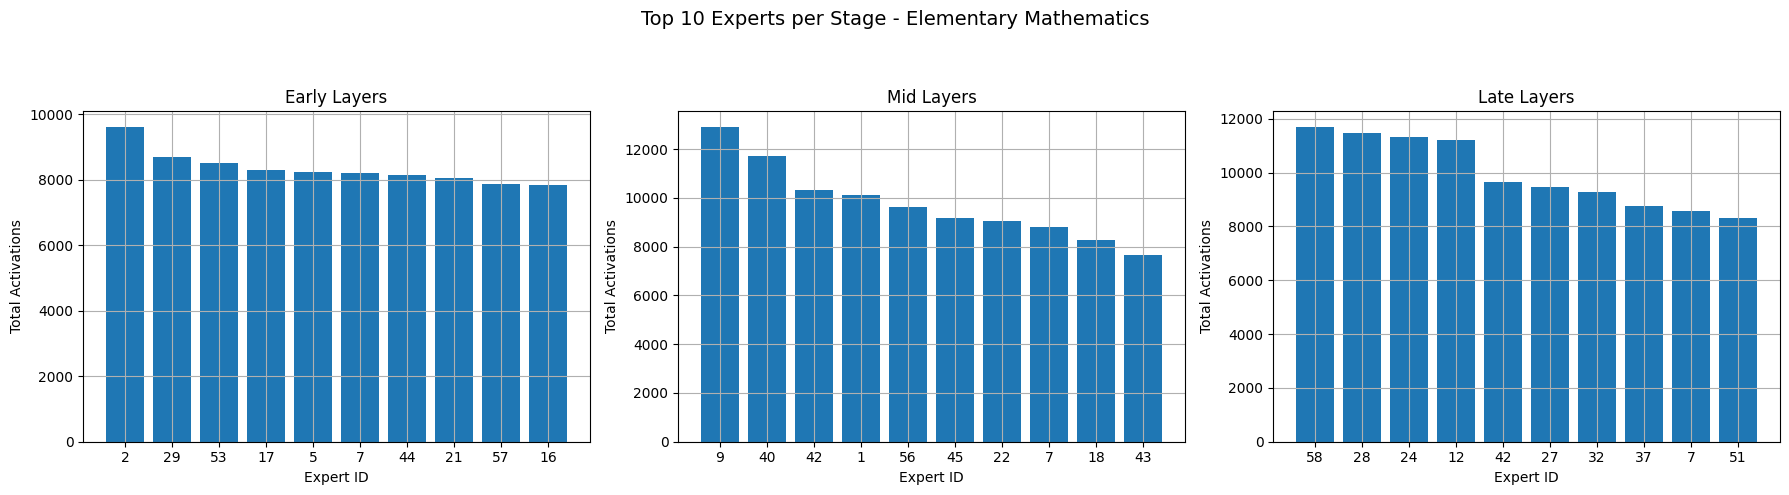

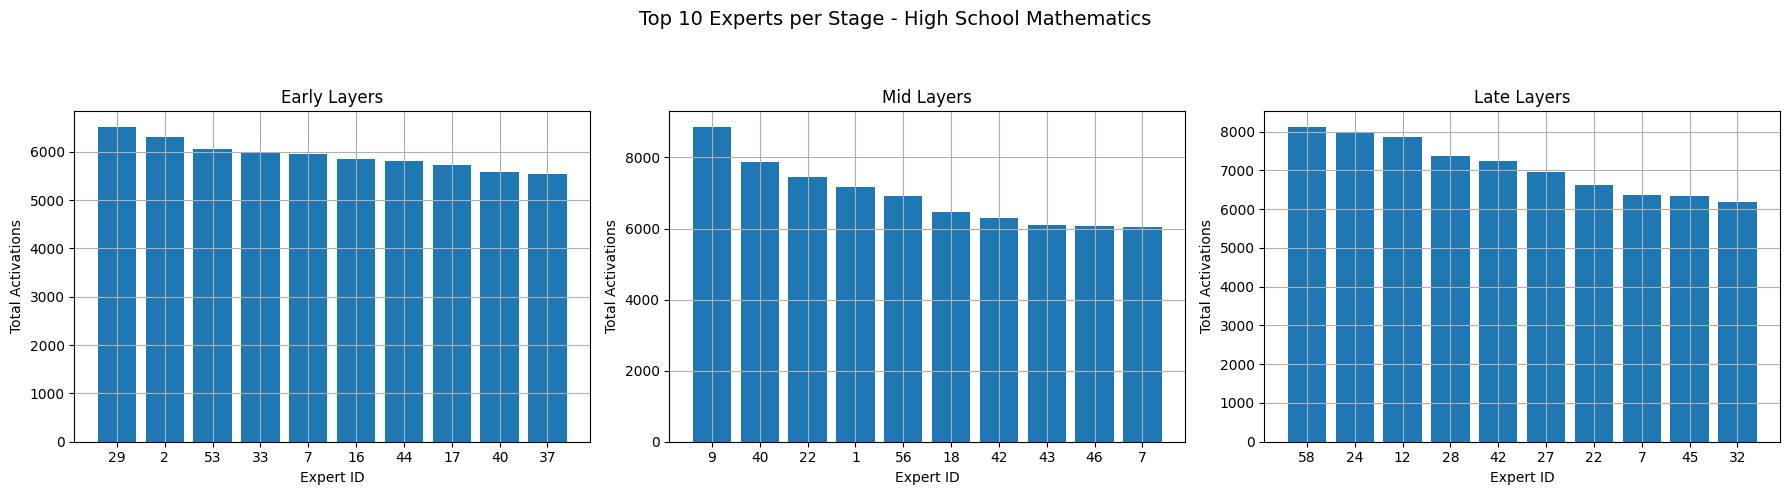

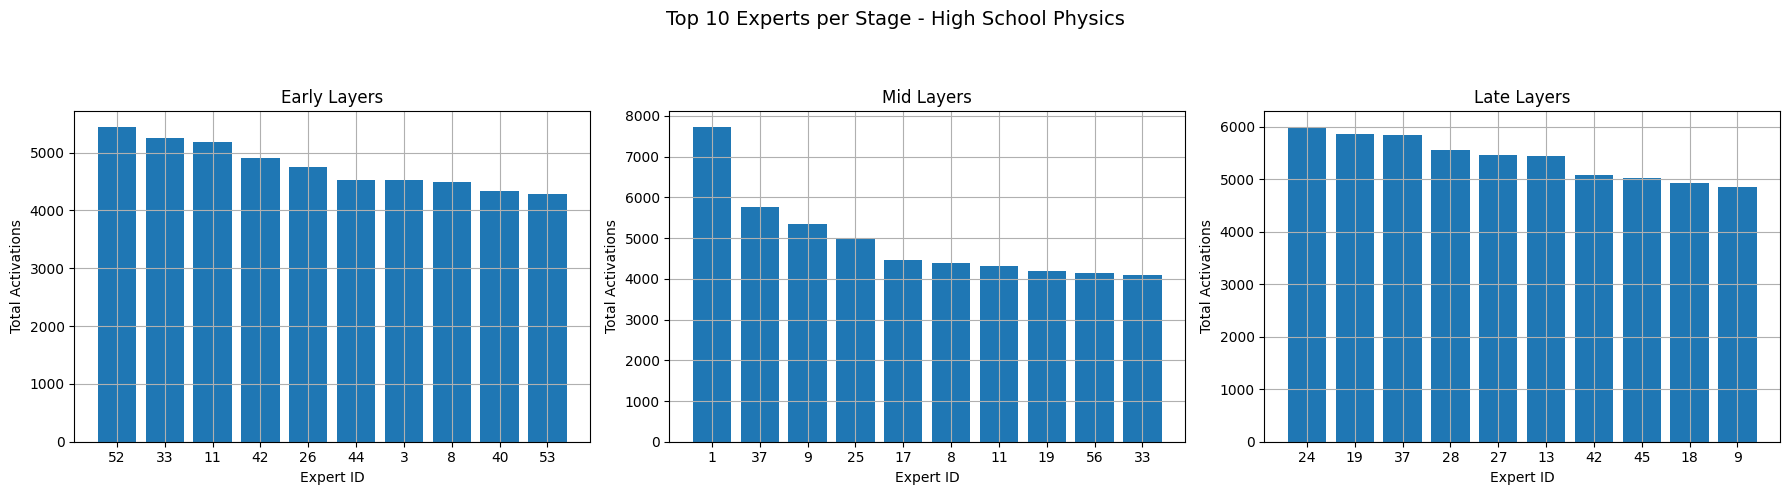

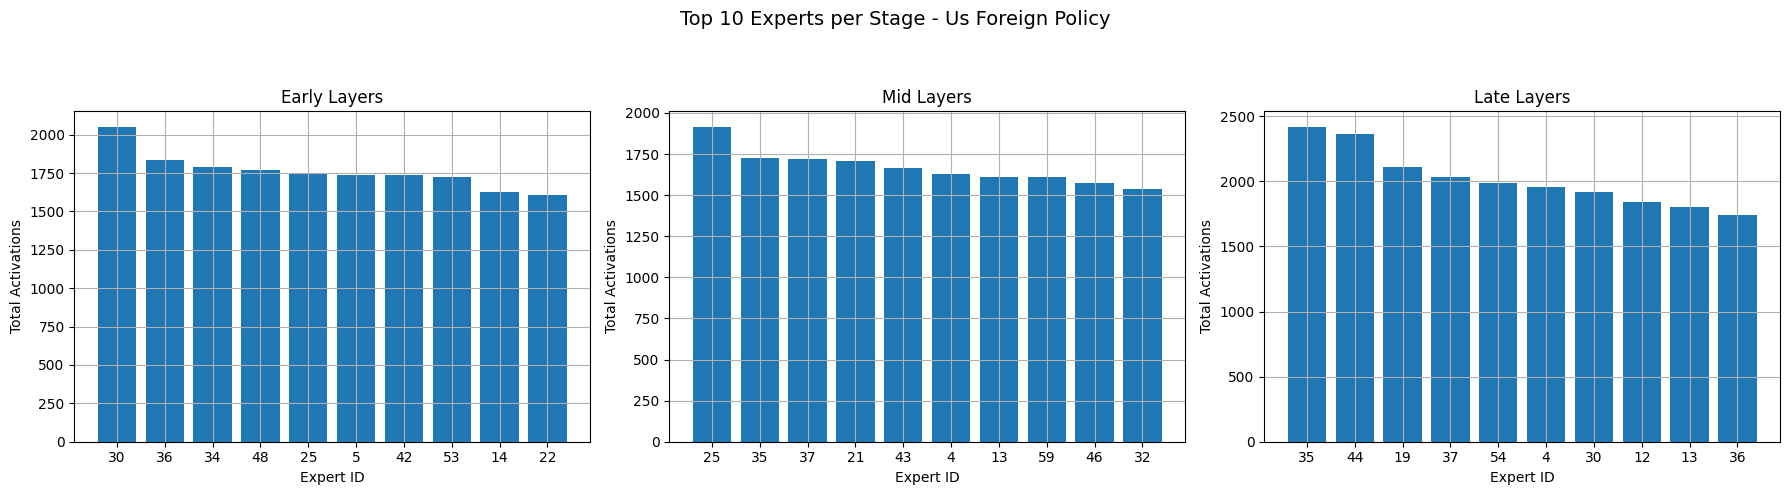

In [ ]:
# Configuration
TOP_N = 10
layer_groups = {
    "early": range(0, 8),
    "mid": range(8, 16),
    "late": range(16, 24)
}

# Plot per subject
for subject in subjects:
    usage = subject_expert_usage[subject]
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Top {TOP_N} Experts per Stage - {subject.replace('_', ' ').title()}", fontsize=14)

    for i, (stage, layers) in enumerate(layer_groups.items()):
        # Sum expert usage across the selected layers
        total_counts = np.zeros(60)
        for layer in layers:
            total_counts += np.array(usage[layer])

        # Get top-N experts
        top_indices = np.argsort(total_counts)[::-1][:TOP_N]
        top_values = total_counts[top_indices]

        # Plot
        axes[i].bar(range(TOP_N), top_values, tick_label=top_indices)
        axes[i].set_title(f"{stage.title()} Layers")
        axes[i].set_xlabel("Expert ID")
        axes[i].set_ylabel("Total Activations")
        axes[i].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(f"{subject}_top_{TOP_N}_experts_per_stage.png", dpi=300)
    plt.show()


In [ ]:
for name, module in model.named_modules():
    print(name)
    if "router" in name.lower():
        print(name, "→", module.__class__.__name__)


model
model.embed_tokens
model.layers
model.layers.0
model.layers.0.self_attn
model.layers.0.self_attn.q_proj
model.layers.0.self_attn.k_proj
model.layers.0.self_attn.v_proj
model.layers.0.self_attn.o_proj
model.layers.0.self_attn.rotary_emb
model.layers.0.mlp
model.layers.0.mlp.gate
model.layers.0.mlp.experts
model.layers.0.mlp.experts.0
model.layers.0.mlp.experts.0.gate_proj
model.layers.0.mlp.experts.0.up_proj
model.layers.0.mlp.experts.0.down_proj
model.layers.0.mlp.experts.0.act_fn
model.layers.0.mlp.experts.1
model.layers.0.mlp.experts.1.gate_proj
model.layers.0.mlp.experts.1.up_proj
model.layers.0.mlp.experts.1.down_proj
model.layers.0.mlp.experts.1.act_fn
model.layers.0.mlp.experts.2
model.layers.0.mlp.experts.2.gate_proj
model.layers.0.mlp.experts.2.up_proj
model.layers.0.mlp.experts.2.down_proj
model.layers.0.mlp.experts.2.act_fn
model.layers.0.mlp.experts.3
model.layers.0.mlp.experts.3.gate_proj
model.layers.0.mlp.experts.3.up_proj
model.layers.0.mlp.experts.3.down_proj
mod

In [ ]:
print(model.named_modules())

<generator object Module.named_modules at 0x7b2dc98bc260>
